In [77]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split, cross_val_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline, FunctionTransformer
import types
import seaborn as sns
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from functools import cache
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
np.set_printoptions(precision=6, suppress=True)

In [2]:
# pip install scikeras[tensorflow]

In [3]:
    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

@cache
def transform_channel_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def transform_data_per_event(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(pca.transform(event).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list.T

@cache
def umap_transform_channel_per_channel(array_name:str,umap):
    array = globals()[array_name]
    transform_list = []
    for channel in range(64):
        transform_list.append(umap.transform(array[:,channel,:]).T)
    transform_list = np.stack(transform_list, axis=2) 
    return transform_list

@cache
def transform_channel_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_channel_per_event(array_name,pca))

@cache
def transform_data_per_event_csp(array_name:str,pca,csp):

    return csp.transform(transform_data_per_event(array_name,pca))

@cache
def transform_csp(array_name:str,csp):
    array = globals()[array_name]
    return csp.transform(array)

@cache
def concat_channels(array_name:str):
    array = globals()[array_name]
    list_array = []
    for event in array:
        list_array.append(np.concatenate(event))
    return np.vstack(list_array)

@cache
def transform_all_concat(array_name:str,pca):
    return pca.transform(concat_channels(array_name))

@cache
def transform_channel_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event.T)))
    transform_list = np.vstack(transform_list) 
    return transform_list

@cache
def transform_data_concat(array_name:str,pca):
    array = globals()[array_name]
    transform_list = []
    for event in array:
        transform_list.append(np.concatenate(pca.transform(event).T))
    transform_list = np.vstack(transform_list) 
    return transform_list


def create_model(my_params):
    model = tf.keras.Sequential(my_params["layers"])
    model.compile(
        optimizer=my_params["optimizer"],
        loss=my_params["loss"],
        metrics=my_params["metrics"])
    return model

class Pipe:

    def __init__(self,name, model, processed_X_train,processed_X_val, adapter = None):
        self.name = name
        self.model = model
        self.processed_X_train = processed_X_train
        self.processed_X_val = processed_X_val
        if adapter is not None:
            self.adapter = FunctionTransformer(adapter)
        else:
            self.adapter = None
        
    def create_pipeline(self):
        if self.adapter is not None:
            return Pipeline([
                ('adapter', self.adapter),
                ('model', self.model)
            ])
        else:
            return Pipeline([
                ('model', self.model)
            ])


In [4]:
metrics = []
subjects_range = range(1, 10)
for subject in subjects_range:
    fileName = f'../../datasources/BCICIV_2a_gdf/A{subject:02d}T.gdf'

    if subject == subjects_range[0]:
        raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)
    else:
        new_raw = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'], verbose=0)
        raw = mne.io.concatenate_raws([raw, new_raw])
            


c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)
c:\Users\Vinícius\anaconda3\lib\contextlib.py:142: RuntimeWarning: Cha

In [5]:
raw_backup = raw.copy()

In [6]:
raw = raw_backup.copy()

In [7]:
names = {'EEG-Fz':'Fz',
 'EEG-0':'FC3',
 'EEG-1':'FC1',
 'EEG-2':'FCz',
 'EEG-3':'FC2',
 'EEG-4':'FC4',
 'EEG-5':'C5',
 'EEG-C3':'C3',
 'EEG-6':'C1',
 'EEG-Cz':'Cz',
 'EEG-7':'C2',
 'EEG-C4':'C4',
 'EEG-8':'C6',
 'EEG-9':'CP3',
 'EEG-10':'CP1',
 'EEG-11':'CPz',
 'EEG-12':'CP2',
 'EEG-13':'CP4',
 'EEG-14':'P1',
 'EEG-Pz':'Pz',
 'EEG-15':'P2',
 'EEG-16':'POz',
 'EOG-left':'EOG-left',
 'EOG-central':'EOG-central',
 'EOG-right':'EOG-right'}
raw.rename_channels(names)
raw.set_channel_types({channel:"eeg" for channel in raw.ch_names})

# Add positions to channels
mne.datasets.eegbci.standardize(raw)  # set channel names

montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage,on_missing ='warn')

raw.set_channel_types({'EOG-LEFT':'eog',
 'EOG-CENTRAL':'eog',
 'EOG-RIGHT':'eog'})

raw.annotations.rename({'769':"left", '770':"right"})

events = mne.events_from_annotations(raw)
# Apply band-pass filter
raw.filter(5.0, 42.0, fir_design="firwin", skip_by_annotation="edge")


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '771', '772', 'left', 'right']
Filtering raw data in 9 contiguous segments


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_14424\1845888783.py:33: RuntimeWarning: DigMontage is only a subset of info. There are 3 channel positions not present in the DigMontage. The channels missing from the montage are:

['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  raw.set_montage(montage,on_missing ='warn')


Setting up band-pass filter from 5 - 42 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 42.00 Hz
- Upper transition bandwidth: 10.50 Hz (-6 dB cutoff frequency: 47.25 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.5s finished


<RawGDF | A01T.gdf, 25 x 6005911 (24023.6 s), ~1.12 GB, data loaded>

In [8]:
# raw.load_data()
# raw.set_eeg_reference("average")
# eog_epochs = mne.preprocessing.create_eog_epochs(raw, l_freq=5.0, h_freq=42)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average("all")

# model_evoked = mne.preprocessing.EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
# raw_clean = model_evoked.apply(raw)

raw_clean = raw


In [9]:
raw_clean.drop_channels(['EOG-LEFT', 'EOG-CENTRAL', 'EOG-RIGHT'])
picks = mne.pick_types(raw_clean.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
tmin, tmax = -1.0, 4.0


epochs = mne.Epochs(
    raw_clean,
    event_id=[7, 8],
    events = events[0],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)


Not setting metadata
1296 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1296 events and 1251 original time points ...
0 bad epochs dropped


In [10]:


# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.

# The fixation cue start seems to be the event start, which takes 1,25 seconds. Removing 2 seconds from start for task assimilation. The event takes 6s +- 1s, to avoid adaptation, but the BCI only takes 3s.

epochs_train = epochs.copy().crop(tmin=2.0, tmax=4.0)
labels = epochs.events[:, -1] - 2

In [11]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


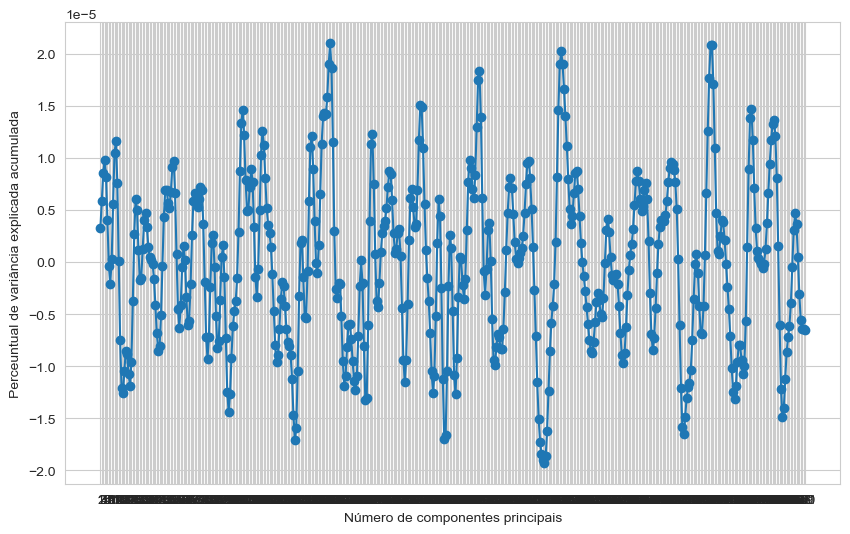

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(epochs_data_train[0][0])+1))
ax.plot(eixo_x, epochs_data_train[0][0], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [13]:
epochs_data_train.shape
# Number of events , channels, each measurement (f*t)

(1296, 22, 501)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(epochs_data_train, labels, test_size=0.3,shuffle = False, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,shuffle = False, random_state=42)


In [15]:
concat_X_train = concat_channels("X_train")

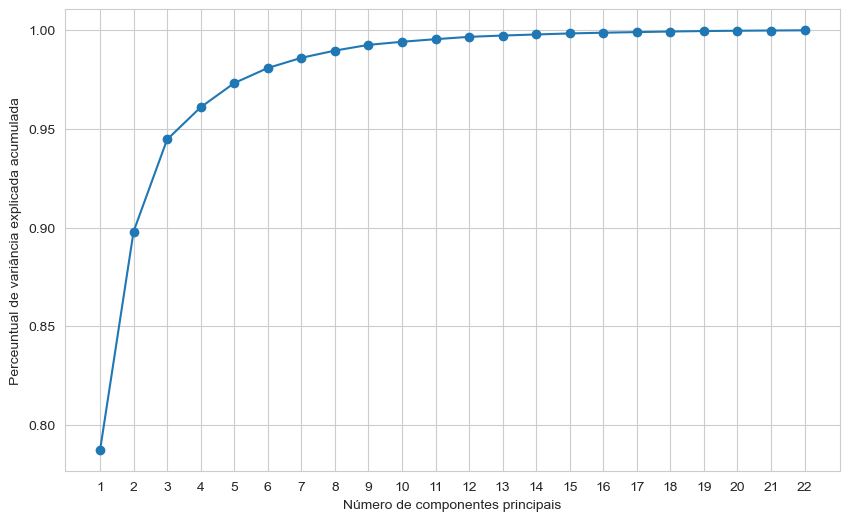

[0.787145 0.898039 0.944682 0.961023 0.973256 0.9809   0.986059 0.98972
 0.992621 0.994193 0.995509 0.996691 0.997349 0.997897 0.998412 0.998791
 0.9991   0.999388 0.999635 0.999784 0.999903 1.      ] 0.9897203647782845


In [16]:
pca_channel = PCA(random_state=42,)
for event in X_train:
    pca_channel.fit(event.T)

variancia_explicada_acumulada_channel = np.cumsum(pca_channel.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel,variancia_explicada_acumulada_channel[8-1])

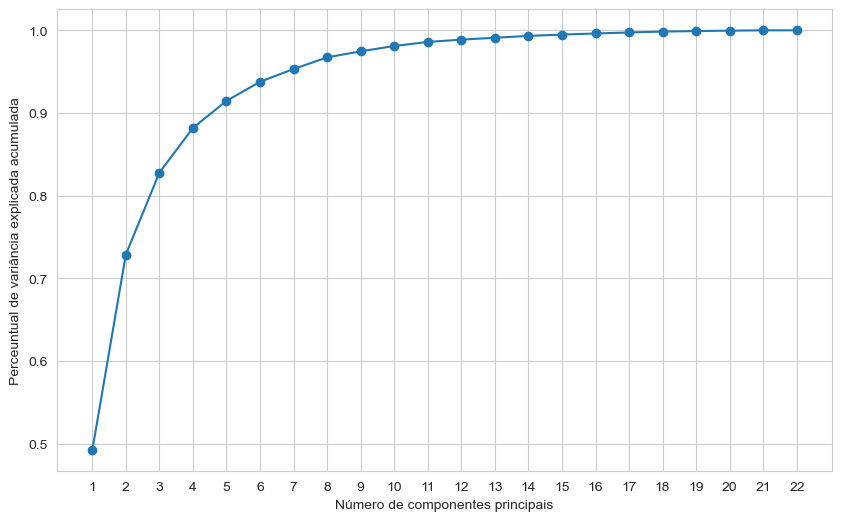

[0.491985 0.728784 0.827791 0.88197  0.914631 0.937733 0.953209 0.967258
 0.974616 0.980997 0.98596  0.988721 0.991019 0.993228 0.994854 0.99615
 0.997419 0.998457 0.999086 0.999588 1.       1.      ] 0.9746155134290203


In [17]:
pca_data = PCA(random_state=42,)
for event in X_train:
    pca_data.fit(event)

variancia_explicada_acumulada_data = np.cumsum(pca_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_data,variancia_explicada_acumulada_data[9-1])

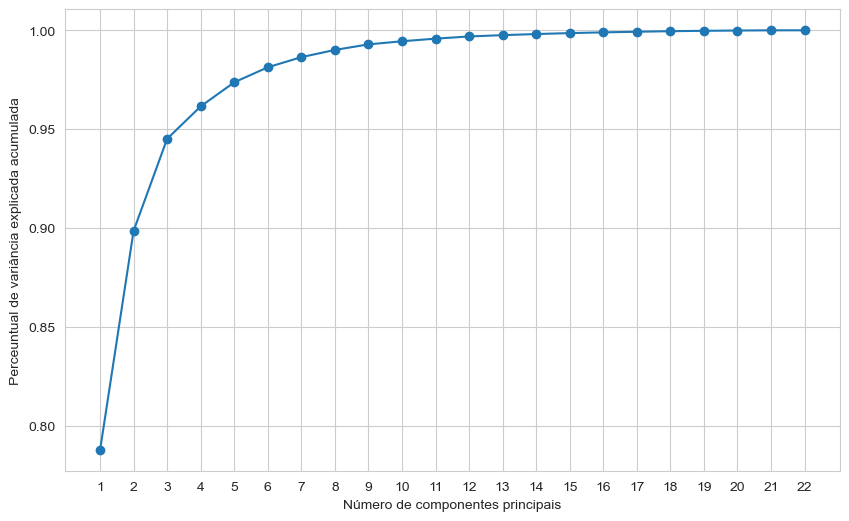

[0.787672 0.898615 0.945142 0.961558 0.97371  0.981313 0.986438 0.990076
 0.992893 0.994471 0.995793 0.996896 0.997555 0.998114 0.998594 0.998966
 0.999279 0.999555 0.999751 0.99989  1.       1.      ] 0.9900762586644524


In [18]:
pca_channel_data = PCA(random_state=42,)
for event in transform_channel_per_event("X_train",pca_channel):
    pca_channel_data.fit(event)

variancia_explicada_acumulada_channel_data = np.cumsum(pca_channel_data.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada_channel_data)+1))
ax.plot(eixo_x, variancia_explicada_acumulada_channel_data, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_channel_data,variancia_explicada_acumulada_channel_data[8-1])

In [19]:
pca_all = PCA(random_state=42,)

pca_all.fit(concat_X_train)

PCA(random_state=42)

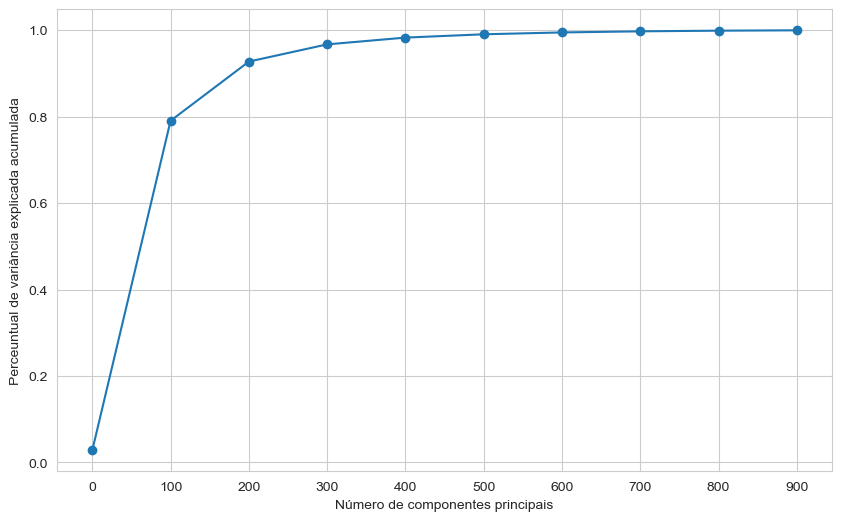

[0.028033 0.052316 0.076214 0.098545 0.119926 0.140729 0.161014 0.180866
 0.199736 0.21761  0.234788 0.251343 0.267481 0.283482 0.299034 0.314153
 0.329158 0.343431 0.357276 0.370976 0.384118 0.397202 0.409774 0.42211
 0.433992 0.445497 0.456783 0.467455 0.477969 0.488137 0.49786  0.506433
 0.514632 0.521804 0.528806 0.535581 0.542259 0.548725 0.554841 0.560712
 0.566537 0.572182 0.577737 0.583219 0.588561 0.593833 0.598989 0.604105
 0.608994 0.613748 0.618412 0.623061 0.62768  0.632254 0.636692 0.641062
 0.645407 0.64973  0.653937 0.658108 0.6622   0.666243 0.670221 0.674167
 0.678086 0.681939 0.68567  0.689379 0.693049 0.696701 0.700279 0.703841
 0.707385 0.710912 0.714378 0.71782  0.721251 0.724623 0.727908 0.731151
 0.734355 0.73752  0.740645 0.743728 0.746784 0.749819 0.752812 0.755762
 0.758675 0.761539 0.764379 0.767163 0.769923 0.772642 0.77533  0.777966
 0.780564 0.783157 0.785699 0.788205 0.790665 0.793116 0.795517 0.797865
 0.800189 0.802502 0.804781 0.807031 0.809245 0.8114

In [20]:

variancia_explicada_acumulada_all = np.cumsum(pca_all.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(0, len(variancia_explicada_acumulada_all)+1,100))
ax.plot(eixo_x, variancia_explicada_acumulada_all[0::100], marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()
print(variancia_explicada_acumulada_all,variancia_explicada_acumulada_all[400-1])

In [21]:
del pca_all
del pca_data
del pca_channel_data
del pca_channel


In [22]:
del variancia_explicada_acumulada_all
del variancia_explicada_acumulada_channel
del variancia_explicada_acumulada_channel_data
del variancia_explicada_acumulada_data

In [23]:
pca12_channel = PCA(random_state=42,n_components=8)
for event in X_train:
    pca12_channel.fit(event.T)

In [24]:
pca16_data = PCA(random_state=42,n_components=8)
for event in X_train:
    pca16_data.fit(event)

In [25]:
pca900_all = PCA(random_state=42,n_components=400)
pca900_all.fit(concat_X_train)

PCA(n_components=400, random_state=42)

In [26]:
X_train.shape

(907, 22, 501)

In [27]:
csp15 = mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
csp15.fit(X_train, y_train)

Computing rank from data with rank=None


    Using tolerance 7.3e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [28]:

csp4 = mne.decoding.CSP(n_components=1, reg=None, log=True, norm_trace=False)
csp4.fit(X_train, y_train)

Computing rank from data with rank=None


    Using tolerance 7.3e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 1,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [29]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp4 = mne.decoding.CSP(n_components=1, reg=None, log=True, norm_trace=False)
pca12_channel_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 2.7e-05 (2.2e-16 eps * 8 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-05 (2.2e-16 eps * 8 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 1,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [30]:
transform_list = []
for event in X_train:
    transform_list.append(pca12_channel.transform(event.T))
transform_list = np.stack(transform_list, axis=2) 

pca12_channel_csp15 = mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
pca12_channel_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 2.7e-05 (2.2e-16 eps * 8 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.7e-05 (2.2e-16 eps * 8 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [31]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp4 = mne.decoding.CSP(n_components=1, reg=None, log=True, norm_trace=False)
pca16_data_csp4.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 22 dim * 8.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 22 dim * 8.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 1,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [32]:
transform_list = []
for event in X_train:
    transform_list.append(pca16_data.transform(event).T)
transform_list = np.stack(transform_list, axis=2) 

pca16_data_csp15 = mne.decoding.CSP(n_components=2, reg=None, log=True, norm_trace=False)
pca16_data_csp15.fit(transform_list.T, y_train)

Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 22 dim * 8.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 22 dim * 8.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.


CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 2,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'})

In [33]:
# umap15_unsup = UMAP(n_components=15,random_state=42,n_neighbors=30,min_dist=0.05)
# umap15_unsup.fit(X_train[:,0,:])

In [34]:
# umap15 = UMAP(n_components=16,random_state=42,n_neighbors=30,min_dist=0.05)
# for channel in range(64):
#     umap15.fit(X_train[:,channel,:],y_train)

In [35]:
# a = umap15.transform(X_val[:,0,:])
# fig, ax = plt.subplots()
# sns.scatterplot(ax = ax, x = a[:,0],y=  a[:,1], hue =  y_val,palette="tab10")
# ax.set_ylabel("Segunda componente")
# ax.set_xlabel("Primeira Componente")
# ax.legend(["Classe","T0","T1","T2"])
# ax.set_xticks(list(range(3, 6+1))) 
# ax.set_yticks(list(range(-2, 2+1)))
# plt.show()

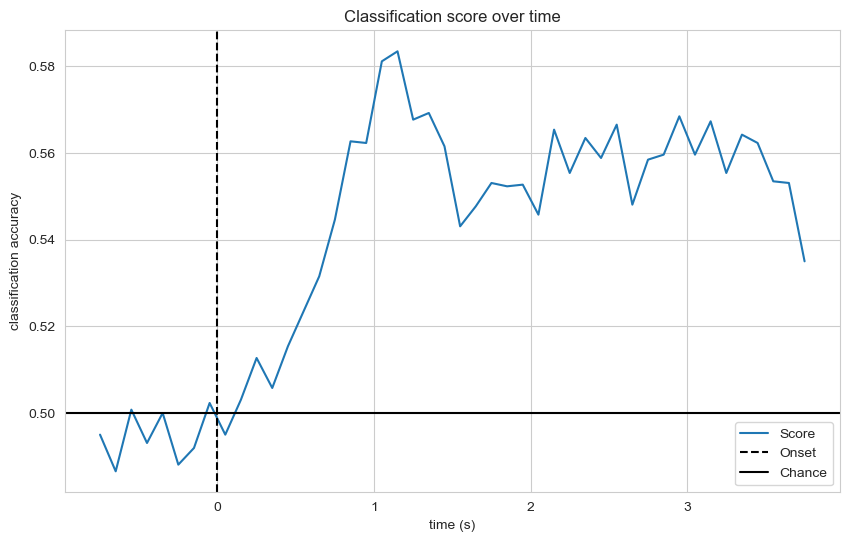

In [36]:
epochs_data_local = epochs.get_data()
epochs_data_train_local = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train_local)
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_local.shape[2] - w_length, w_step)
lda = LinearDiscriminantAnalysis()

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]

    X_train_local = csp4.transform(epochs_data_train_local[train_idx])

    # fit classifier
    lda.fit(X_train_local, y_train_local)

cv_split = cv.split(epochs_data_train_local)

for train_idx, test_idx in cv_split:
    y_train_local, y_test_local = labels[train_idx], labels[test_idx]
    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test_local = csp4.transform(epochs_data_local[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test_local, y_test_local))
    scores_windows.append(score_this_window)


# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [37]:
X_train.shape

(907, 22, 501)

In [38]:
transform_csp("X_train",csp4).shape

(907, 1)

In [108]:
#Get Indices (it's the same for all, as suffle is False by default)
pipe = mnbc_csp4
pipeline = pipe.create_pipeline()
cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True,return_indices=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

print(f"Results for pipeline with {pipe.name}:")
print("----------------")
print("Test accuracy scores:", cv_results['test_Accuracy'])
print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
print("-----")
print("Test F1 scores:", cv_results['test_F1'])
print("Mean test F1:", cv_results['test_F1'].mean())
print("----------------")
print("train accuracy scores:", cv_results['train_Accuracy'])
print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
print("-----")
print("train F1 scores:", cv_results['train_F1'])
print("Mean train F1:", cv_results['train_F1'].mean())
print("----------------")
print("Fit time:", cv_results['fit_time'])
print("Score time:", cv_results['score_time'])
print()
print("--------------------------------------------------------------------------------------------")

indices = cv_results["indices"]["test"]

Results for pipeline with mnbc_csp4:
----------------
Test accuracy scores: [0.494505 0.494505 0.494505 0.494505 0.494505 0.494505 0.494505 0.5
 0.5      0.5     ]
Mean test accuracy: 0.49615384615384617
-----
Test F1 scores: [0.330882 0.330882 0.330882 0.330882 0.330882 0.330882 0.330882 0.333333
 0.333333 0.333333]
Mean test F1: 0.3316176470588236
----------------
train accuracy scores: [0.5      0.5      0.5      0.5      0.501225 0.501225 0.501225 0.500612
 0.500612 0.500612]
Mean train accuracy: 0.5005512455900354
-----
train F1 scores: [0.333333 0.333333 0.333333 0.333333 0.333878 0.333878 0.333878 0.333605
 0.333605 0.333605]
Mean train F1: 0.33357816470797125
----------------
Fit time: [0.002043 0.001662 0.001453 0.001136 0.008935 0.002002 0.001994 0.002554
 0.001001 0.001997]
Score time: [0.001999 0.001999 0.002023 0.       0.001997 0.003297 0.002879 0.002997
 0.002998 0.001295]

--------------------------------------------------------------------------------------------


In [101]:
mnbc_csp.processed_X_train.shape

(907, 2)

In [105]:
def aff(array):
    X_std = (array - np.min(array)) / (np.max(array) - np.min(array))
    X_scaled = X_std * (1-0)+0
    return X_scaled

In [109]:
# lda_plain = Pipe("lda_csp4",LinearDiscriminantAnalysis(),concat_channels("X_train") ) - Takes too long
lda_csp4 = Pipe("lda_csp4",LinearDiscriminantAnalysis(),transform_csp("X_train",csp4),transform_csp("X_val",csp4) )
lda_csp15 = Pipe("lda_csp15",LinearDiscriminantAnalysis(),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
lda_pca12_channel_csp4 = Pipe("lda_pca12_channel_csp4",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
lda_pca16_data_csp4 = Pipe("lda_pca16_data_csp4",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
lda_pca900_all = Pipe("lda_pca900_all",LinearDiscriminantAnalysis(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
lda_pca12_channel = Pipe("lda_pca12_channel",LinearDiscriminantAnalysis(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
lda_pca16_data = Pipe("lda_pca16_data",LinearDiscriminantAnalysis(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
lda_pca12_channel_csp15 = Pipe("lda_pca12_channel_csp15",LinearDiscriminantAnalysis(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
lda_pca16_data_csp15 = Pipe("lda_pca16_data_csp15",LinearDiscriminantAnalysis(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
# mnbc_plain = Pipe("mnbc_plain",MultinomialNB(),concat_channels("X_train"),aff)
mnbc_csp4 = Pipe("mnbc_csp4",MultinomialNB(),transform_csp("X_train",csp4),transform_csp("X_val",csp4),aff)
mnbc_csp15 = Pipe("mnbc_csp15",MultinomialNB(),transform_csp("X_train",csp15),transform_csp("X_val",csp15),aff)
mnbc_pca12_channel = Pipe("mnbc_pca12_channel",MultinomialNB(),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel),aff)
mnbc_pca16_data = Pipe("mnbc_pca16_data",MultinomialNB(),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data),aff)
mnbc_pca900_all = Pipe("mnbc_pca900_all",MultinomialNB(),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all),aff)
mnbc_pca12_channel_csp4 = Pipe("mnbc_pca12_channel_csp4",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4),aff)
mnbc_pca16_data_csp4 = Pipe("mnbc_pca16_data_csp4",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4),aff)
mnbc_pca12_channel_csp15 = Pipe("mnbc_pca12_channel_csp15",MultinomialNB(),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15),aff)
mnbc_pca16_data_csp15 = Pipe("mnbc_pca16_data_csp15",MultinomialNB(),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15),aff)
# MLP_plain = Pipe("MLP_plain",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),concat_channels("X_train")) - Takes too long
MLP_csp4 = Pipe("MLP_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
MLP_csp15 = Pipe("MLP_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_csp("X_train",csp15),transform_csp("X_val",csp15))
MLP_pca12_channel = Pipe("MLP_pca12_channel",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
MLP_pca16_data = Pipe("MLP_pca16_data",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
MLP_pca900_all = Pipe("MLP_pca900_all",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))
MLP_pca12_channel_csp4 = Pipe("MLP_pca12_channel_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
MLP_pca16_data_csp4 = Pipe("MLP_pca16_data_csp4",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
MLP_pca12_channel_csp15 = Pipe("MLP_pca12_channel_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))
MLP_pca16_data_csp15 = Pipe("MLP_pca16_data_csp15",MLPClassifier(learning_rate_init= 0.001,max_iter= 5000,momentum= 0.2,hidden_layer_sizes= (100,60,50,1)),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_csp4 = Pipe("Keras_MLP_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp4),transform_csp("X_val",csp4))
Keras_MLP_csp15 = Pipe("Keras_MLP_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_csp("X_train",csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_csp("X_train",csp15),transform_csp("X_val",csp15))

Keras_MLP_pca12_channel = Pipe("Keras_MLP_pca12_channel",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_concat("X_train",pca12_channel).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_concat("X_train",pca12_channel),transform_channel_concat("X_val",pca12_channel))
Keras_MLP_pca16_data = Pipe("Keras_MLP_pca16_data",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_concat("X_train",pca16_data).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_concat("X_train",pca16_data),transform_data_concat("X_val",pca16_data))
Keras_MLP_pca900_all = Pipe("Keras_MLP_pca900_all",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_all_concat("X_train",pca900_all).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_all_concat("X_train",pca900_all),transform_all_concat("X_val",pca900_all))



Keras_MLP_pca16_data_csp4 = Pipe("Keras_MLP_pca16_data_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp4),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp4))
Keras_MLP_pca12_channel_csp4 = Pipe("Keras_MLP_pca12_channel_csp4",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp4),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp4))
Keras_MLP_pca16_data_csp15 = Pipe("Keras_MLP_pca16_data_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_data_per_event_csp("X_train",pca16_data,pca16_data_csp15),transform_data_per_event_csp("X_val",pca16_data,pca16_data_csp15))
Keras_MLP_pca12_channel_csp15 = Pipe("Keras_MLP_pca12_channel_csp15",KerasClassifier(model=create_model, my_params={
        "layers":[
            tf.keras.layers.Dense(15, activation='sigmoid', input_shape=(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1],)),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(20, activation='sigmoid'),
            tf.keras.layers.Dropout(0.5,seed= 42),
            tf.keras.layers.Dense(10, activation='sigmoid'),
            tf.keras.layers.Dense(5, activation='sigmoid'),
            tf.keras.layers.Dense(3, activation='softmax')
        ],
        "optimizer":'adam',
        "loss": 'sparse_categorical_crossentropy',
        "metrics": ['accuracy']
    }, epochs=150, batch_size=32, verbose=0,random_state=42),transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15),transform_channel_per_event_csp("X_val",pca12_channel,pca12_channel_csp15))




Pipes = [
    lda_csp4,
    lda_csp15,
    lda_pca12_channel_csp4,
    lda_pca16_data_csp4,
    lda_pca900_all,
    lda_pca12_channel,
    lda_pca16_data,
    lda_pca12_channel_csp15,
    lda_pca16_data_csp15,
    # mnbc_plain,
    mnbc_csp4,
    mnbc_csp15,
    mnbc_pca12_channel,
    mnbc_pca16_data,
    mnbc_pca900_all,
    mnbc_pca12_channel_csp4,
    mnbc_pca16_data_csp4,
    mnbc_pca12_channel_csp15,
    mnbc_pca16_data_csp15,
    # MLP_plain,
    MLP_csp4,
    MLP_csp15,
    MLP_pca12_channel,
    MLP_pca16_data,
    MLP_pca900_all,
    MLP_pca12_channel_csp4,
    MLP_pca16_data_csp4,
    MLP_pca12_channel_csp15,
    MLP_pca16_data_csp15,
    Keras_MLP_csp4,
    Keras_MLP_csp15,
    Keras_MLP_pca12_channel,
    Keras_MLP_pca16_data,
    Keras_MLP_pca900_all,
    Keras_MLP_pca16_data_csp4,
    Keras_MLP_pca12_channel_csp4,
    Keras_MLP_pca16_data_csp15,
    Keras_MLP_pca12_channel_csp15,
    
    
    
]


In [110]:
results = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    cv_results = cross_validate(pipeline, pipe.processed_X_train, y_train,return_train_score=True,return_estimator=True, cv=10, scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})

    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", cv_results['test_Accuracy'])
    print("Mean test accuracy:", cv_results['test_Accuracy'].mean())
    print("-----")
    print("Test F1 scores:", cv_results['test_F1'])
    print("Mean test F1:", cv_results['test_F1'].mean())
    print("----------------")
    print("train accuracy scores:", cv_results['train_Accuracy'])
    print("Mean train accuracy:", cv_results['train_Accuracy'].mean())
    print("-----")
    print("train F1 scores:", cv_results['train_F1'])
    print("Mean train F1:", cv_results['train_F1'].mean())
    print("----------------")
    print("Fit time:", cv_results['fit_time'])
    print("Score time:", cv_results['score_time'])
    print()
    print("--------------------------------------------------------------------------------------------")

    results[pipe.name] = (cv_results)

lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: [0.637363 0.626374 0.483516 0.615385 0.538462 0.527473 0.505495 0.511111
 0.5      0.633333]
Mean test accuracy: 0.5578510378510378
-----
Test F1 scores: [0.634538 0.625242 0.325926 0.586632 0.521772 0.427673 0.35461  0.405048
 0.333333 0.583975]
Mean test F1: 0.4798749797472408
----------------
train accuracy scores: [0.552696 0.553922 0.580882 0.547794 0.557598 0.569853 0.579657 0.578947
 0.561812 0.547124]
Mean train accuracy: 0.5630284457724338
-----
train F1 scores: [0.551077 0.552737 0.58063  0.546415 0.556783 0.569744 0.579125 0.577986
 0.56023  0.545746]
Mean train F1: 0.5620471618461819
----------------
Fit time: [0.000999 0.001999 0.001999 0.002001 0.000999 0.001    0.002001 0.000991
 0.001    0.001999]
Score time: [0.001998 0.002    0.002    0.001997 0.001617 0.002344 0.002944 0.002989
 0.002877 0.002001]

---------------------------------------------------------------------------------------

In [ ]:
for key, value in results.items(): 
    print(value['test_Accuracy'])
    print(",")

[0.637363 0.626374 0.483516 0.615385 0.538462 0.527473 0.505495 0.511111
 0.5      0.633333]
,
[0.615385 0.549451 0.472527 0.692308 0.549451 0.527473 0.527473 0.522222
 0.477778 0.577778]
,
[0.549451 0.505495 0.450549 0.593407 0.571429 0.461538 0.494505 0.5
 0.5      0.611111]
,
[0.516484 0.538462 0.527473 0.626374 0.461538 0.549451 0.538462 0.488889
 0.455556 0.566667]
,
[0.472527 0.527473 0.527473 0.494505 0.527473 0.505495 0.56044  0.555556
 0.455556 0.522222]
,
[0.472527 0.450549 0.549451 0.494505 0.450549 0.615385 0.472527 0.444444
 0.488889 0.533333]
,
[0.483516 0.549451 0.461538 0.450549 0.549451 0.43956  0.582418 0.544444
 0.533333 0.533333]
,
[0.56044  0.505495 0.450549 0.538462 0.549451 0.461538 0.494505 0.533333
 0.5      0.611111]
,
[0.56044  0.593407 0.527473 0.593407 0.450549 0.56044  0.527473 0.477778
 0.666667 0.7     ]
,
[0.494505 0.494505 0.494505 0.494505 0.494505 0.494505 0.494505 0.5
 0.5      0.5     ]
,
[0.527473 0.406593 0.483516 0.549451 0.736264 0.516484 0.483

In [ ]:
for key, value in results.items(): 
    print(np.mean(value['test_Accuracy']))
    print(",")

0.5578510378510378
,
0.5511843711843711
,
0.5237484737484737
,
0.5269352869352869
,
0.5148717948717948
,
0.49721611721611725
,
0.5127594627594627
,
0.5204884004884004
,
0.5657631257631258
,
0.49615384615384617
,
0.5314407814407814
,
0.4950549450549451
,
0.5016483516483516
,
0.5016483516483516
,
0.49615384615384617
,
0.49615384615384617
,
0.5027594627594627
,
0.5213553113553113
,
0.504932844932845
,
0.5038461538461538
,
0.49945054945054945
,
0.49945054945054945
,
0.5005494505494505
,
0.5148351648351648
,
0.5149572649572649
,
0.5181807081807082
,
0.5049450549450549
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,
0.49835164835164836
,


In [ ]:
for key, value in results.items(): 
    print(np.max(value['test_Accuracy']))
    print(",")

0.6373626373626373
,
0.6923076923076923
,
0.6111111111111112
,
0.6263736263736264
,
0.5604395604395604
,
0.6153846153846154
,
0.5824175824175825
,
0.6111111111111112
,
0.7
,
0.5
,
0.7362637362637363
,
0.5054945054945055
,
0.5604395604395604
,
0.5274725274725275
,
0.5
,
0.5
,
0.5714285714285714
,
0.6043956043956044
,
0.5714285714285714
,
0.5384615384615384
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.6373626373626373
,
0.5666666666666667
,
0.5604395604395604
,
0.5714285714285714
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,
0.5054945054945055
,


In [ ]:
for key, value in results.items(): 
    print(value['test_F1'])
    print(",")

[0.634538 0.625242 0.325926 0.586632 0.521772 0.427673 0.35461  0.405048
 0.333333 0.583975]
,
[0.61464  0.545941 0.380952 0.692271 0.531105 0.523792 0.460796 0.425048
 0.357045 0.516676]
,
[0.441551 0.504537 0.341725 0.576851 0.557757 0.374175 0.406746 0.398306
 0.369061 0.583939]
,
[0.515957 0.533902 0.49814  0.600877 0.444361 0.485876 0.468576 0.414924
 0.358545 0.52381 ]
,
[0.472464 0.525409 0.525409 0.48701  0.527244 0.505256 0.559961 0.555336
 0.455488 0.520743]
,
[0.469388 0.448886 0.547483 0.494444 0.450483 0.61464  0.472464 0.44417
 0.486607 0.533103]
,
[0.481261 0.549233 0.460496 0.449952 0.549233 0.437113 0.581153 0.539843
 0.533333 0.53241 ]
,
[0.448485 0.504537 0.341725 0.5125   0.535078 0.374175 0.406746 0.455645
 0.333333 0.588719]
,
[0.557823 0.591631 0.527244 0.576851 0.439103 0.540404 0.51911  0.469858
 0.6625   0.699071]
,
[0.330882 0.330882 0.330882 0.330882 0.330882 0.330882 0.330882 0.333333
 0.333333 0.333333]
,
[0.51911  0.406522 0.483267 0.521483 0.734694 0.393

In [ ]:
for key, value in results.items(): 
    print(value['train_Accuracy'])
    print(",")

[0.552696 0.553922 0.580882 0.547794 0.557598 0.569853 0.579657 0.578947
 0.561812 0.547124]
,
[0.561275 0.567402 0.577206 0.547794 0.552696 0.569853 0.563725 0.565483
 0.572827 0.560588]
,
[0.520833 0.52451  0.536765 0.514706 0.518382 0.528186 0.531863 0.536108
 0.534884 0.5153  ]
,
[0.522059 0.52451  0.528186 0.508578 0.526961 0.525735 0.526961 0.534884
 0.52142  0.511628]
,
[0.843137 0.849265 0.823529 0.846814 0.832108 0.835784 0.829657 0.838433
 0.839657 0.833537]
,
[0.944853 0.9375   0.947304 0.933824 0.921569 0.9375   0.933824 0.937576
 0.930233 0.927785]
,
[0.688725 0.678922 0.6875   0.689951 0.686275 0.705882 0.678922 0.692778
 0.675643 0.695226]
,
[0.531863 0.525735 0.540441 0.526961 0.523284 0.529412 0.531863 0.529988
 0.52754  0.516524]
,
[0.5625   0.560049 0.566176 0.564951 0.573529 0.561275 0.568627 0.576499
 0.554468 0.55202 ]
,
[0.5      0.5      0.5      0.5      0.501225 0.501225 0.501225 0.500612
 0.500612 0.500612]
,
[0.544118 0.553922 0.550245 0.550245 0.507353 0.53

In [ ]:
for key, value in results.items(): 
    print(np.mean(value['train_Accuracy']))
    print(",")

0.5630284457724338
,
0.5638849389204886
,
0.5261536407708738
,
0.5230921652626779
,
0.8371922024623804
,
0.9351966184270525
,
0.6879823961408309
,
0.5283610231118152
,
0.5640094379244965
,
0.5005512455900354
,
0.5385280917752657
,
0.5325365397076824
,
0.5135414416684666
,
0.5173404612763098
,
0.5005512455900354
,
0.5005512455900354
,
0.5108435632514939
,
0.5200276897784818
,
0.5425776093791249
,
0.5181986044111647
,
0.5003061475508196
,
0.5000610495116039
,
0.5001837485300118
,
0.5126838985288118
,
0.5196526927784577
,
0.5295803633570932
,
0.5321688926488589
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,
0.5005512455900354
,


In [ ]:
for key, value in results.items(): 
    print(np.max(value['train_Accuracy']))
    print(",")

0.5808823529411765
,
0.5772058823529411
,
0.5367647058823529
,
0.5348837209302325
,
0.8492647058823529
,
0.9473039215686274
,
0.7058823529411765
,
0.5404411764705882
,
0.576499388004896
,
0.5012254901960784
,
0.553921568627451
,
0.6102941176470589
,
0.5343137254901961
,
0.5919117647058824
,
0.5012254901960784
,
0.5012254901960784
,
0.5269607843137255
,
0.5343137254901961
,
0.5821078431372549
,
0.5931372549019608
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5661764705882353
,
0.5740514075887393
,
0.5882352941176471
,
0.6102941176470589
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,
0.5012254901960784
,


In [ ]:
for key, value in results.items(): 
    print(value['train_F1'])
    print(",")

[0.551077 0.552737 0.58063  0.546415 0.556783 0.569744 0.579125 0.577986
 0.56023  0.545746]
,
[0.560681 0.566855 0.577063 0.547141 0.551872 0.56962  0.563408 0.565168
 0.572394 0.559825]
,
[0.520383 0.52437  0.536665 0.514563 0.518382 0.527811 0.531761 0.536105
 0.534877 0.515264]
,
[0.521645 0.524027 0.527981 0.507868 0.526551 0.5257   0.526935 0.534766
 0.521006 0.510969]
,
[0.843136 0.849254 0.823528 0.846812 0.832102 0.835784 0.82965  0.838346
 0.839657 0.833525]
,
[0.944853 0.937492 0.947298 0.933823 0.921567 0.937499 0.933823 0.937571
 0.930232 0.927784]
,
[0.688658 0.678827 0.687462 0.689947 0.686244 0.705866 0.678904 0.692688
 0.675641 0.69521 ]
,
[0.531522 0.525615 0.540407 0.521395 0.523163 0.529069 0.531761 0.529953
 0.52742  0.516512]
,
[0.562447 0.560043 0.566153 0.564841 0.573529 0.561275 0.568604 0.576499
 0.554462 0.551987]
,
[0.333333 0.333333 0.333333 0.333333 0.333878 0.333878 0.333878 0.333605
 0.333605 0.333605]
,
[0.544115 0.553897 0.550093 0.550212 0.468736 0.51

In [ ]:
for key, value in results.items(): 
    print(value['fit_time'])
    print(",")

[0.059231 0.031023 0.001545 0.       0.       0.       0.       0.
 0.       0.      ]
,
[0.014574 0.002605 0.00378  0.003659 0.003386 0.004784 0.001679 0.
 0.       0.001999]
,
[0.       0.015627 0.       0.       0.       0.       0.       0.
 0.       0.      ]
,
[0.       0.       0.       0.       0.       0.       0.015628 0.
 0.       0.      ]
,
[0.078123 0.062498 0.066646 0.0625   0.062499 0.0625   0.062501 0.062499
 0.062501 0.074569]
,
[1.589332 1.57651  1.57813  1.569272 1.593843 1.612965 1.60362  1.61138
 1.584983 1.555044]
,
[0.0171   0.024858 0.030503 0.027648 0.024073 0.029825 0.039028 0.129724
 0.027177 0.109867]
,
[0.       0.001    0.       0.       0.001    0.       0.003212 0.
 0.       0.      ]
,
[0.001002 0.001001 0.       0.       0.007739 0.002186 0.       0.001
 0.       0.      ]
,
[0.003966 0.001743 0.007117 0.001    0.001    0.       0.001001 0.001
 0.       0.007401]
,
[0.001    0.       0.       0.       0.000999 0.002019 0.       0.00712
 0.001001 0.001

In [ ]:
for key, value in results.items(): 
    print(value['score_time'])
    print(",")

[0.       0.002692 0.       0.       0.       0.       0.       0.
 0.0092   0.      ]
,
[0.001999 0.003167 0.003117 0.002996 0.003362 0.001999 0.       0.
 0.015628 0.00105 ]
,
[0.       0.       0.       0.015626 0.       0.015623 0.       0.015625
 0.       0.      ]
,
[0.       0.       0.       0.       0.       0.       0.       0.
 0.015624 0.      ]
,
[0.015627 0.015628 0.       0.       0.       0.015625 0.       0.
 0.       0.001999]
,
[0.       0.015627 0.       0.       0.       0.007686 0.       0.
 0.003002 0.      ]
,
[0.       0.002283 0.002998 0.007732 0.       0.002619 0.003194 0.002259
 0.       0.      ]
,
[0.007698 0.002246 0.006841 0.007726 0.002257 0.007632 0.       0.
 0.015629 0.007383]
,
[0.002998 0.001998 0.       0.       0.001999 0.       0.008726 0.002176
 0.006876 0.      ]
,
[0.001999 0.       0.002021 0.001935 0.001725 0.       0.001998 0.002
 0.       0.      ]
,
[0.004222 0.006474 0.       0.       0.002001 0.002    0.       0.00202
 0.002    0.00169

- Todos os modelos que receberam apenas PCA não foram capaz de apresentar uma acurária significativamente maior que chance level.
- O melhor modelo em todas as configurações foi a junção do PCA_data com CSP15
- Em todos os modelos, a segunda maior média pertence ao modelo CSP15 ou PCA_data com CSP4
- O melhor modelo foi o LDA, seguido pelo Keras

In [ ]:
f = []
for key, value in results.items(): 
    f.append(value['train_Accuracy'])

np.mean(np.array(f), axis=0)

array([0.542688, 0.548203, 0.549939, 0.54136 , 0.540986, 0.542109,
       0.540543, 0.544234, 0.537468, 0.535734])

In [ ]:
f = []
for key, value in results.items(): 
    f.append(value['test_Accuracy'])

np.mean(np.array(f), axis=0)

array([0.512515, 0.515873, 0.496032, 0.523504, 0.512515, 0.503053,
       0.504579, 0.499383, 0.506173, 0.526235])

Podemos notar que a última separação de treino e teste teve um resultado notavelmente maior que os demais, enquanto as separações 2,3,7,8 foram as piores.

In [ ]:
X_train[indices[9]].shape

(90, 22, 501)

In [ ]:
np.floor(np.sqrt(transform_channel_per_event_csp("X_train",pca12_channel,pca12_channel_csp15).shape[1]+3))

2.0

In [ ]:
mnbc_csp15.model.score(mnbc_csp15.processed_X_train,np.where(y_train == 5, 6, np.where(y_train == 6, 5, y_train)))

0.5303197353914002

In [ ]:
mnbc_csp15.model.score(np.abs(mnbc_csp15.processed_X_train),y_train)

0.538037486218302

lda_csp4
Results for pipeline with lda_csp4:
----------------
Test accuracy scores: 0.5501285347043702
----------------
train accuracy scores: 0.5611907386990077

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.7632    0.1487    0.2489       195
           6     0.5271    0.9536    0.6789       194

    accuracy                         0.5501       389
   macro avg     0.6451    0.5512    0.4639       389
weighted avg     0.6454    0.5501    0.4634       389



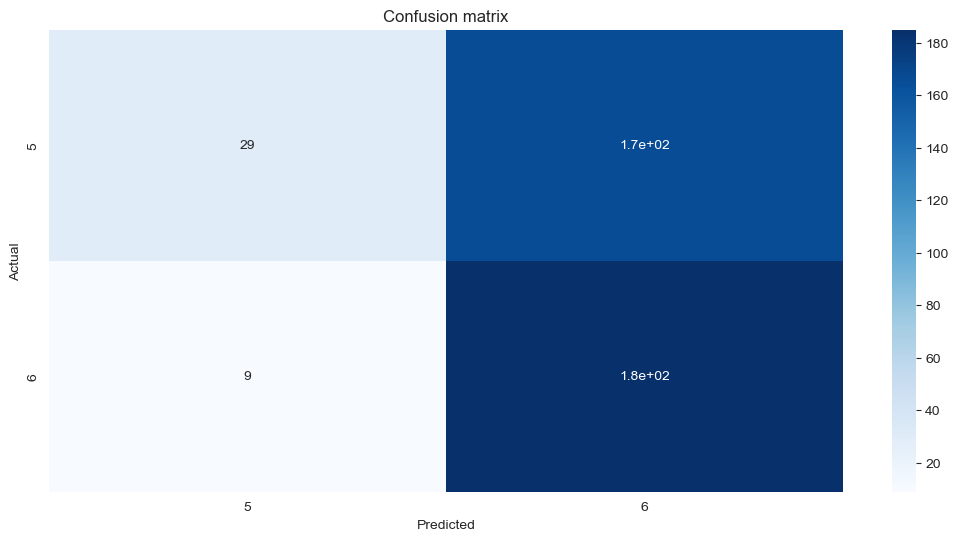

lda_csp15
Results for pipeline with lda_csp15:
----------------
Test accuracy scores: 0.5629820051413882
----------------
train accuracy scores: 0.5644983461962514

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.7193    0.2103    0.3254       195
           6     0.5361    0.9175    0.6768       194

    accuracy                         0.5630       389
   macro avg     0.6277    0.5639    0.5011       389
weighted avg     0.6280    0.5630    0.5006       389



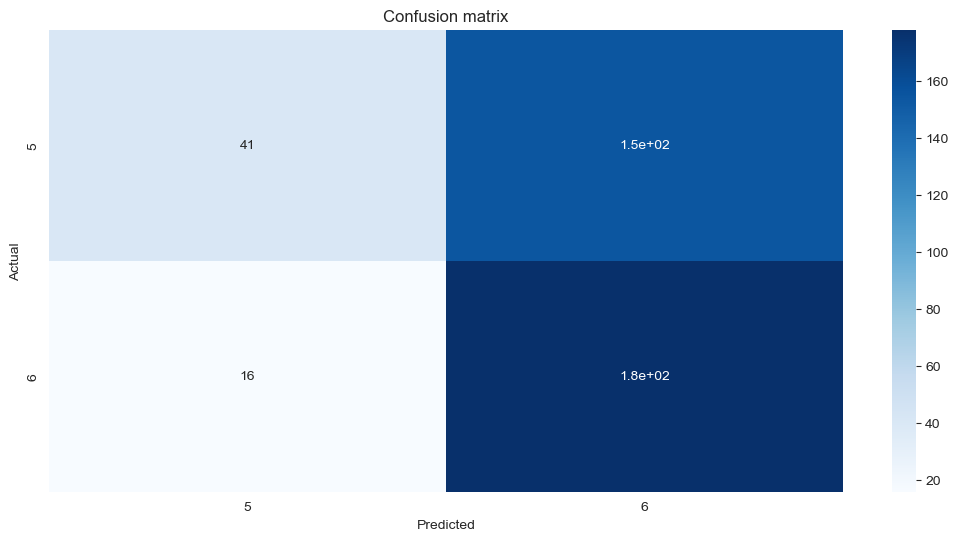

lda_pca12_channel_csp4
Results for pipeline with lda_pca12_channel_csp4:
----------------
Test accuracy scores: 0.5424164524421594
----------------
train accuracy scores: 0.523704520396913

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.6308    0.2103    0.3154       195
           6     0.5247    0.8763    0.6564       194

    accuracy                         0.5424       389
   macro avg     0.5777    0.5433    0.4859       389
weighted avg     0.5779    0.5424    0.4854       389



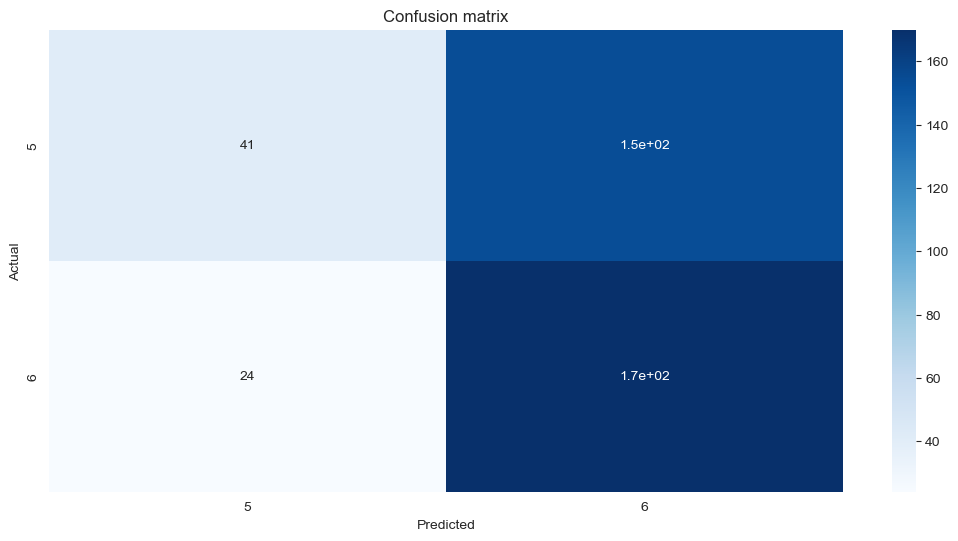

lda_pca16_data_csp4
Results for pipeline with lda_pca16_data_csp4:
----------------
Test accuracy scores: 0.5398457583547558
----------------
train accuracy scores: 0.5214994487320838

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.6081    0.2308    0.3346       195
           6     0.5238    0.8505    0.6483       194

    accuracy                         0.5398       389
   macro avg     0.5660    0.5406    0.4915       389
weighted avg     0.5661    0.5398    0.4910       389



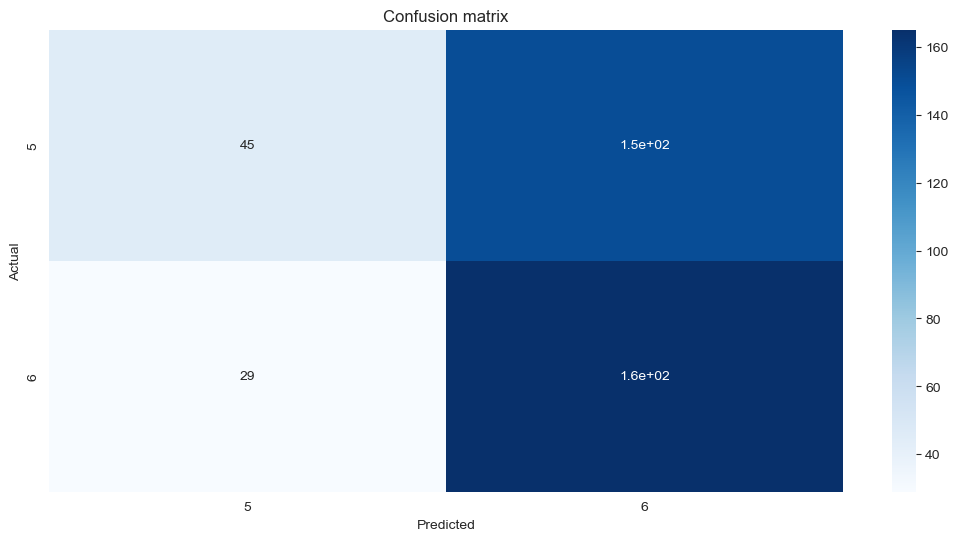

lda_pca900_all
Results for pipeline with lda_pca900_all:
----------------
Test accuracy scores: 0.480719794344473
----------------
train accuracy scores: 0.8136714443219405

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.4824    0.4923    0.4873       195
           6     0.4789    0.4691    0.4740       194

    accuracy                         0.4807       389
   macro avg     0.4807    0.4807    0.4806       389
weighted avg     0.4807    0.4807    0.4807       389



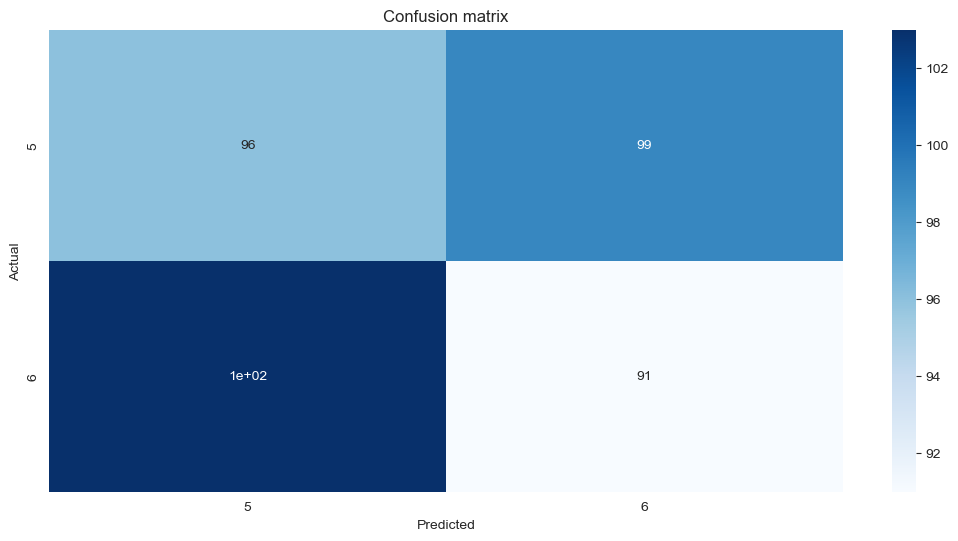

lda_pca12_channel
Results for pipeline with lda_pca12_channel:
----------------
Test accuracy scores: 0.4781491002570694
----------------
train accuracy scores: 0.9492833517089305

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.4804    0.5026    0.4912       195
           6     0.4757    0.4536    0.4644       194

    accuracy                         0.4781       389
   macro avg     0.4780    0.4781    0.4778       389
weighted avg     0.4780    0.4781    0.4778       389



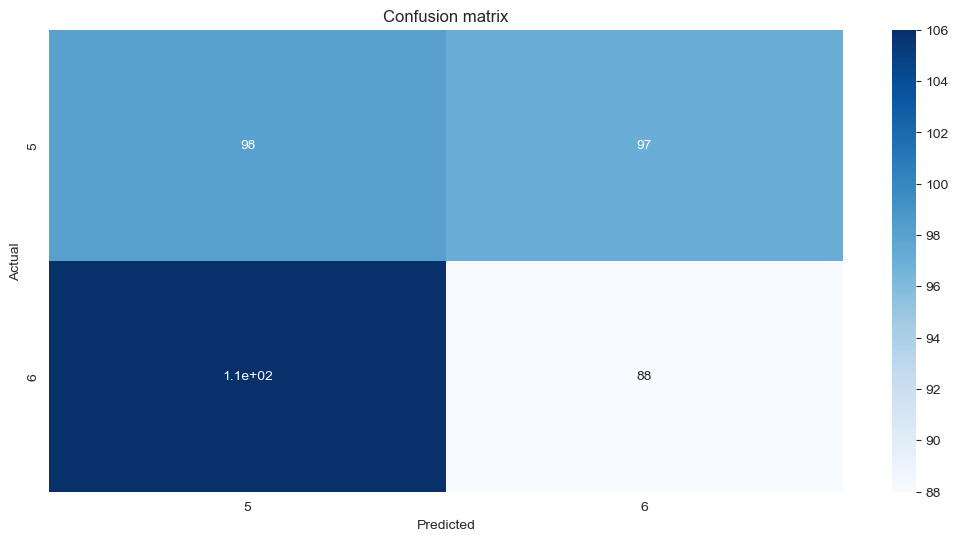

lda_pca16_data
Results for pipeline with lda_pca16_data:
----------------
Test accuracy scores: 0.493573264781491
----------------
train accuracy scores: 0.6747519294377067

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.4947    0.4769    0.4856       195
           6     0.4925    0.5103    0.5013       194

    accuracy                         0.4936       389
   macro avg     0.4936    0.4936    0.4935       389
weighted avg     0.4936    0.4936    0.4934       389



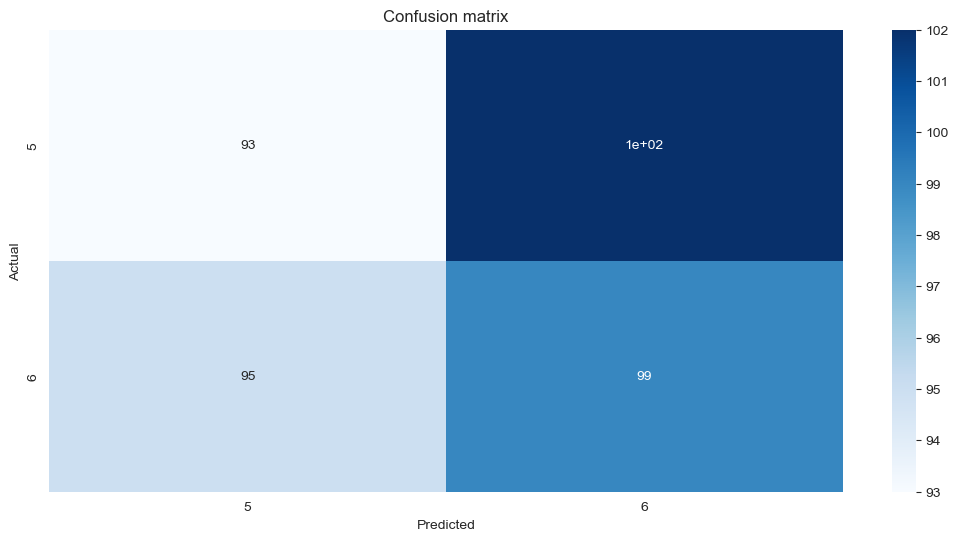

lda_pca12_channel_csp15
Results for pipeline with lda_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5449871465295629
----------------
train accuracy scores: 0.5270121278941565

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.6364    0.2154    0.3218       195
           6     0.5263    0.8763    0.6576       194

    accuracy                         0.5450       389
   macro avg     0.5813    0.5458    0.4897       389
weighted avg     0.5815    0.5450    0.4893       389



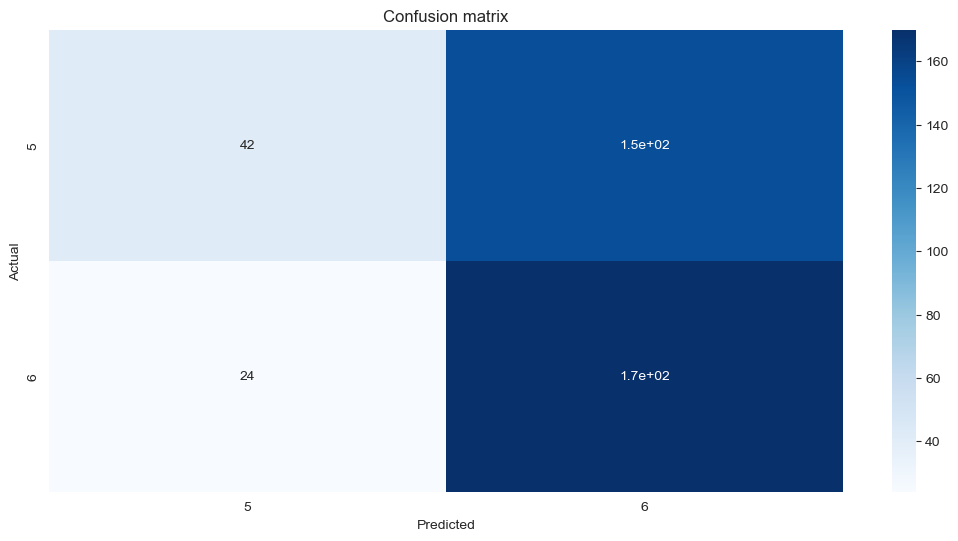

lda_pca16_data_csp15
Results for pipeline with lda_pca16_data_csp15:
----------------
Test accuracy scores: 0.4781491002570694
----------------
train accuracy scores: 0.5644983461962514

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.4701    0.3231    0.3830       195
           6     0.4824    0.6340    0.5479       194

    accuracy                         0.4781       389
   macro avg     0.4763    0.4785    0.4654       389
weighted avg     0.4762    0.4781    0.4652       389



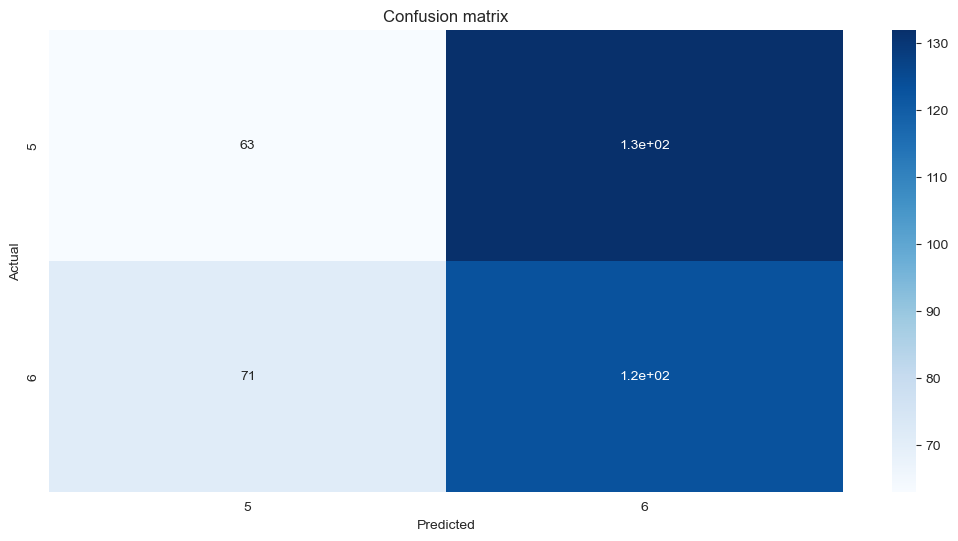

mnbc_csp4
Results for pipeline with mnbc_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


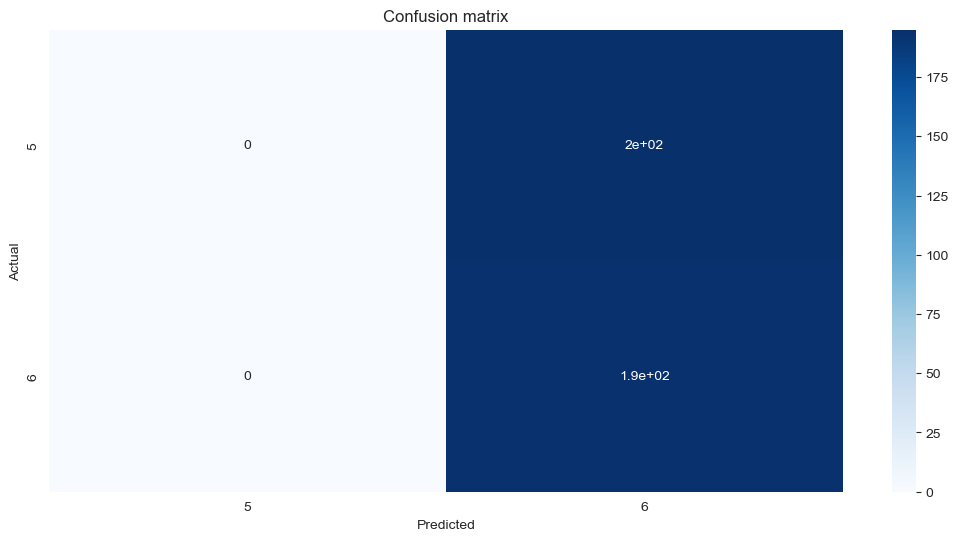

mnbc_csp15
Results for pipeline with mnbc_csp15:
----------------
Test accuracy scores: 0.4498714652956298
----------------
train accuracy scores: 0.538037486218302

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.4062    0.4000    0.4031       195
           6     0.4061    0.4124    0.4092       194

    accuracy                         0.4062       389
   macro avg     0.4062    0.4062    0.4062       389
weighted avg     0.4062    0.4062    0.4061       389



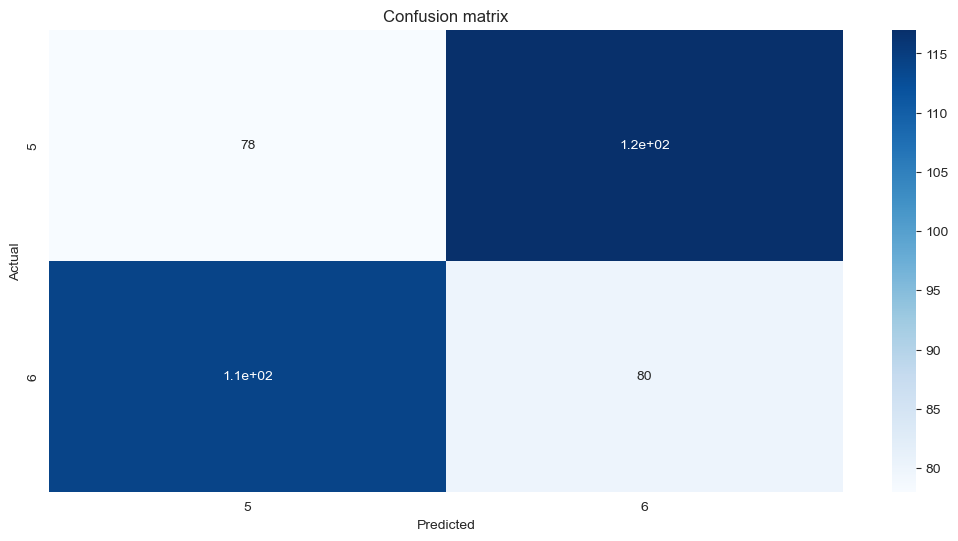

mnbc_pca12_channel
Results for pipeline with mnbc_pca12_channel:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


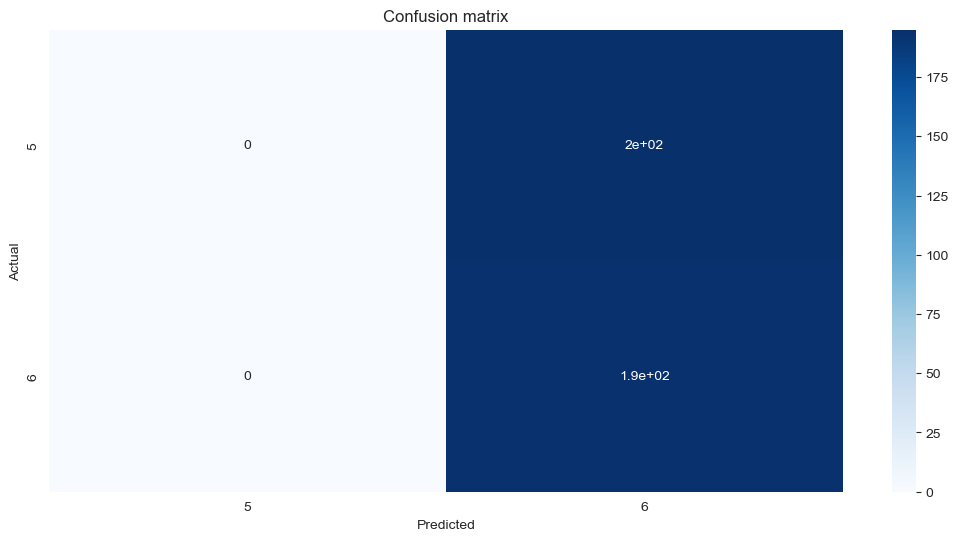

mnbc_pca16_data
Results for pipeline with mnbc_pca16_data:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


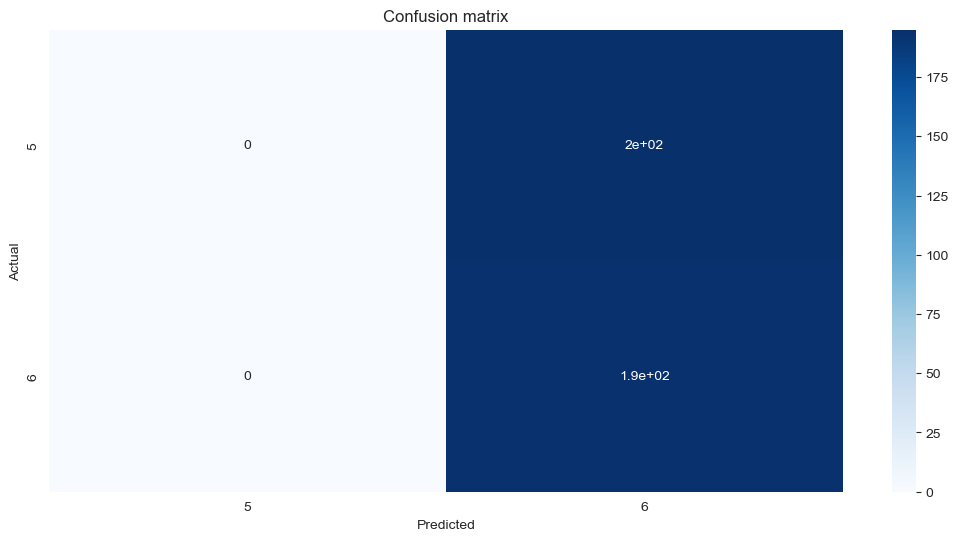

mnbc_pca900_all
Results for pipeline with mnbc_pca900_all:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


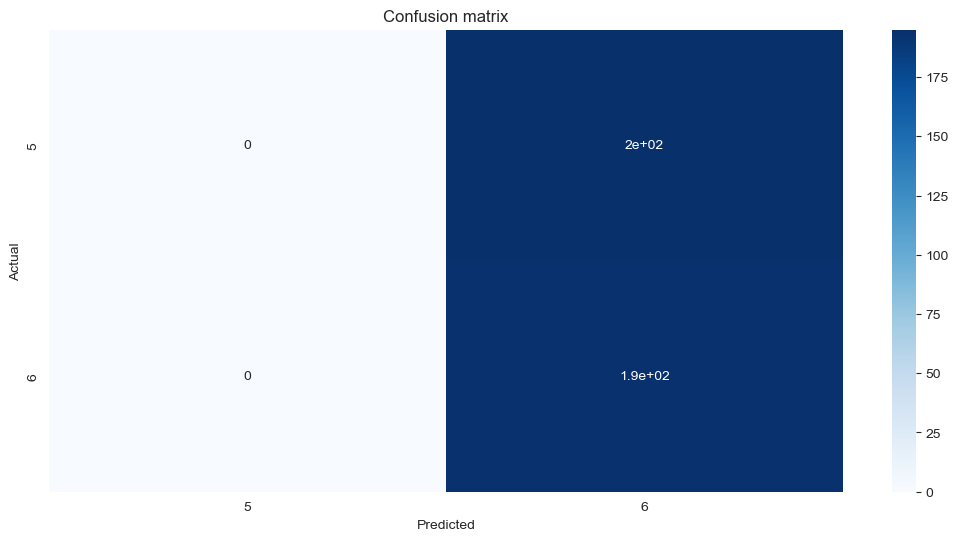

mnbc_pca12_channel_csp4
Results for pipeline with mnbc_pca12_channel_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


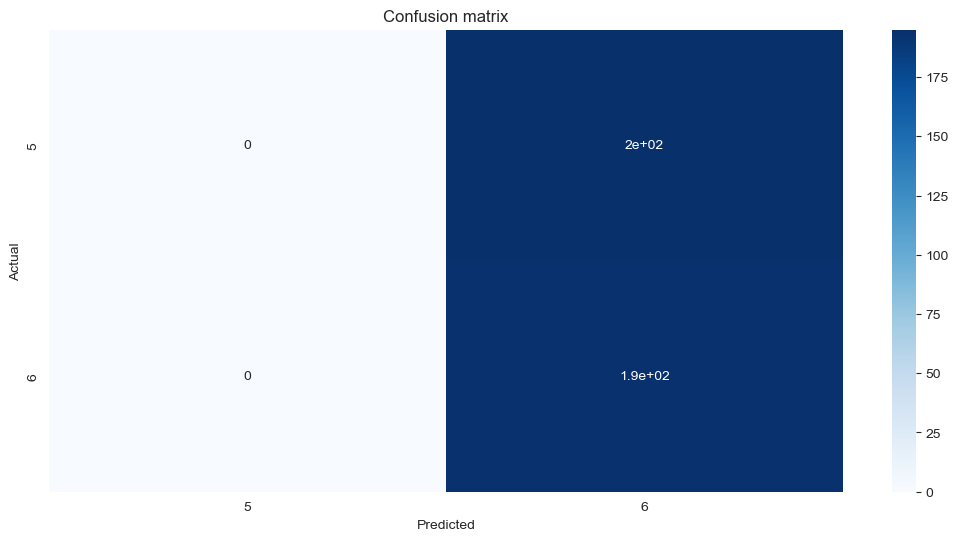

mnbc_pca16_data_csp4
Results for pipeline with mnbc_pca16_data_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


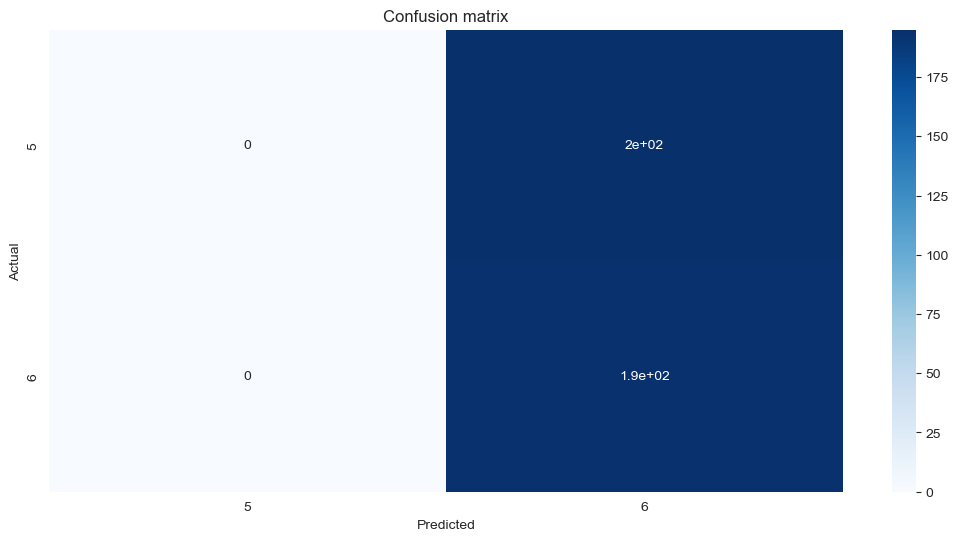

mnbc_pca12_channel_csp15
Results for pipeline with mnbc_pca12_channel_csp15:
----------------
Test accuracy scores: 0.506426735218509
----------------
train accuracy scores: 0.5093715545755237

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.4521    0.3385    0.3871       195
           6     0.4691    0.5876    0.5217       194

    accuracy                         0.4627       389
   macro avg     0.4606    0.4630    0.4544       389
weighted avg     0.4606    0.4627    0.4542       389



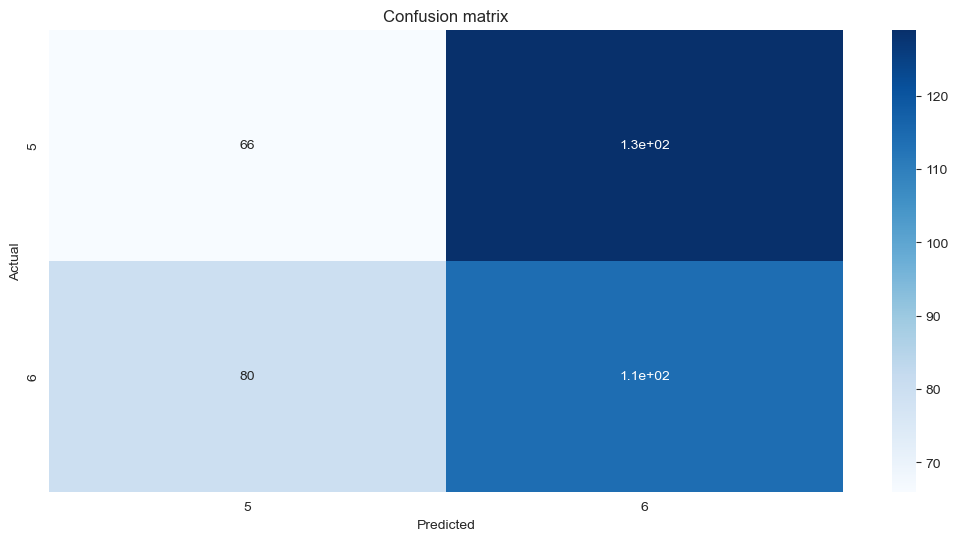

mnbc_pca16_data_csp15
Results for pipeline with mnbc_pca16_data_csp15:
----------------
Test accuracy scores: 0.43958868894601544
----------------
train accuracy scores: 0.5226019845644984

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.5187    0.6410    0.5734       195
           6     0.5270    0.4021    0.4561       194

    accuracy                         0.5219       389
   macro avg     0.5228    0.5215    0.5148       389
weighted avg     0.5228    0.5219    0.5149       389



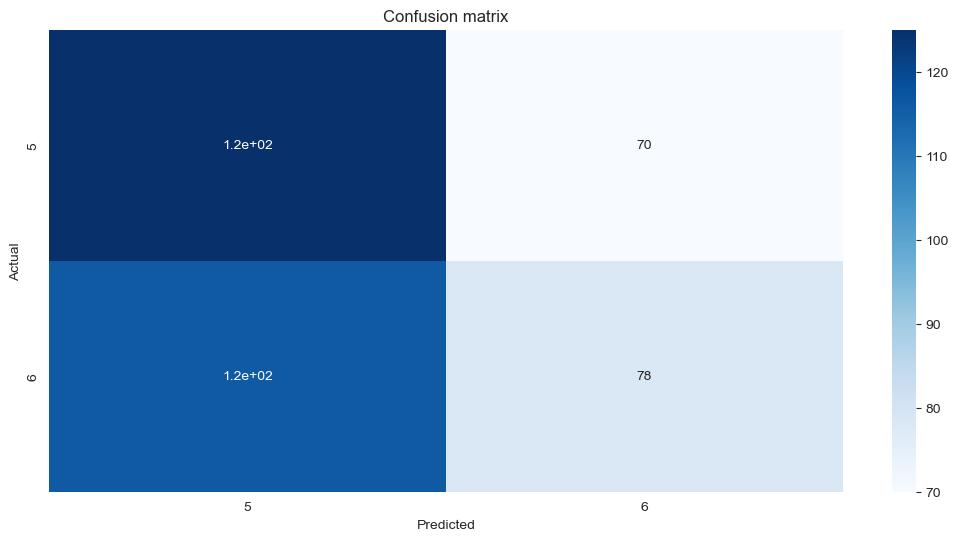

MLP_csp4
Results for pipeline with MLP_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


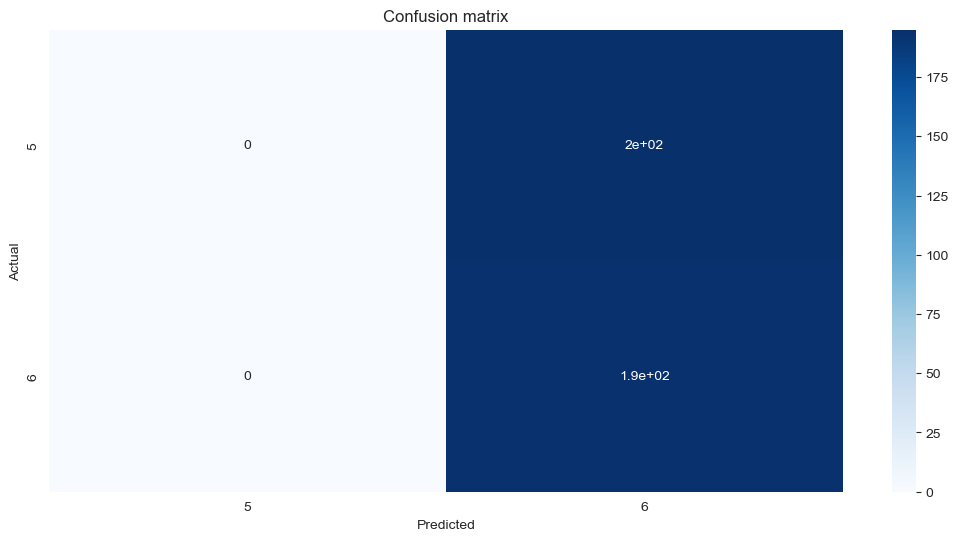

MLP_csp15
Results for pipeline with MLP_csp15:
----------------
Test accuracy scores: 0.5655526992287918
----------------
train accuracy scores: 0.5854465270121278

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.6083    0.3744    0.4635       195
           6     0.5465    0.7577    0.6350       194

    accuracy                         0.5656       389
   macro avg     0.5774    0.5660    0.5492       389
weighted avg     0.5775    0.5656    0.5490       389



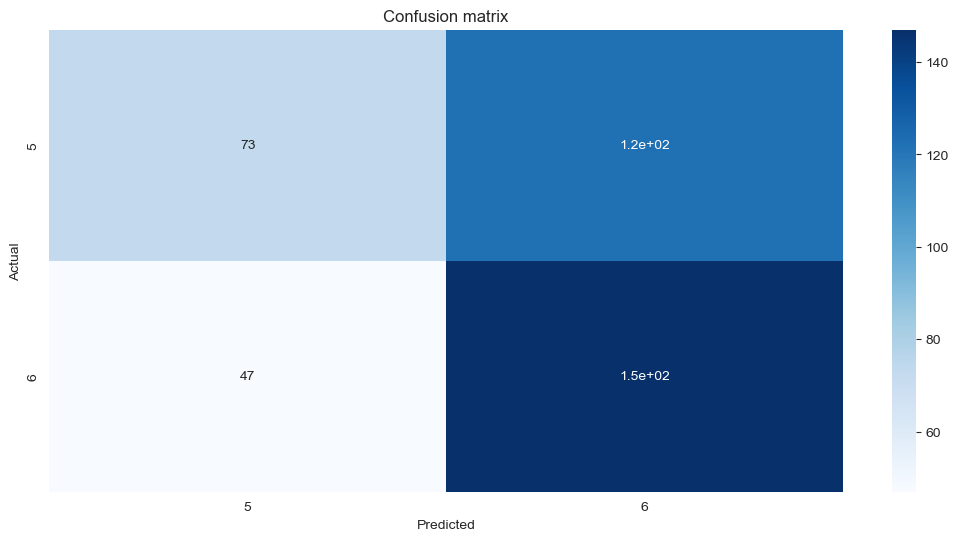

MLP_pca12_channel
Results for pipeline with MLP_pca12_channel:
----------------
Test accuracy scores: 0.5012853470437018
----------------
train accuracy scores: 0.4994487320837927

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


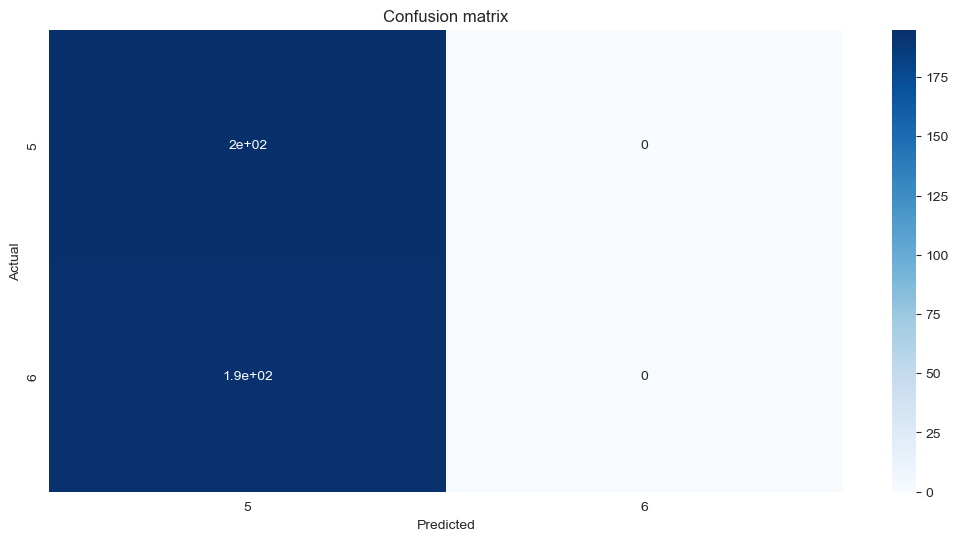

MLP_pca16_data
Results for pipeline with MLP_pca16_data:
----------------
Test accuracy scores: 0.5012853470437018
----------------
train accuracy scores: 0.4994487320837927

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


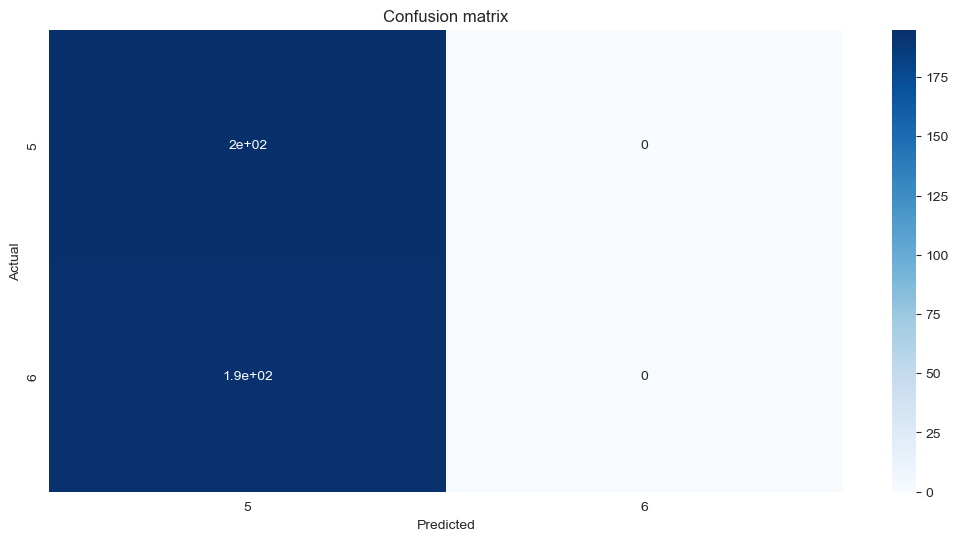

MLP_pca900_all
Results for pipeline with MLP_pca900_all:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


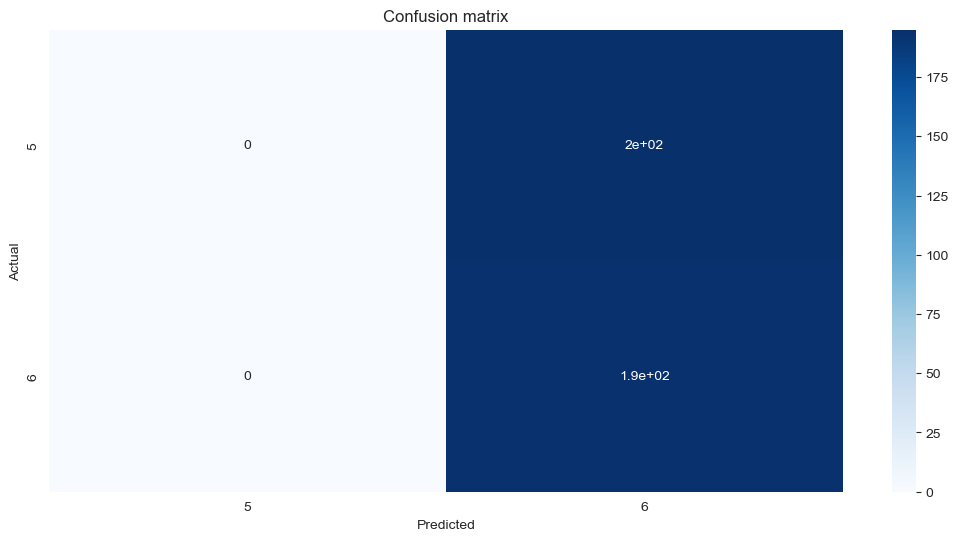

MLP_pca12_channel_csp4
Results for pipeline with MLP_pca12_channel_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


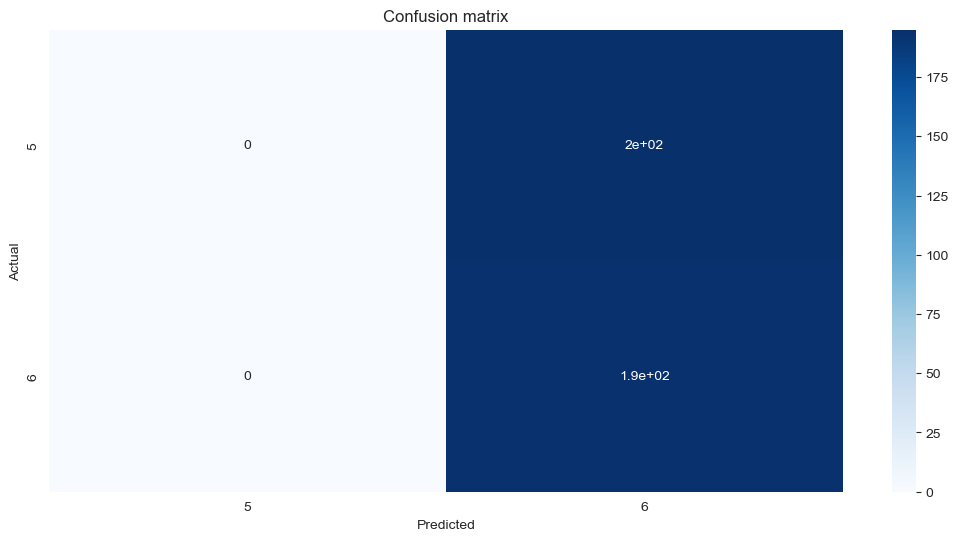

MLP_pca16_data_csp4
Results for pipeline with MLP_pca16_data_csp4:
----------------
Test accuracy scores: 0.5012853470437018
----------------
train accuracy scores: 0.4994487320837927

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


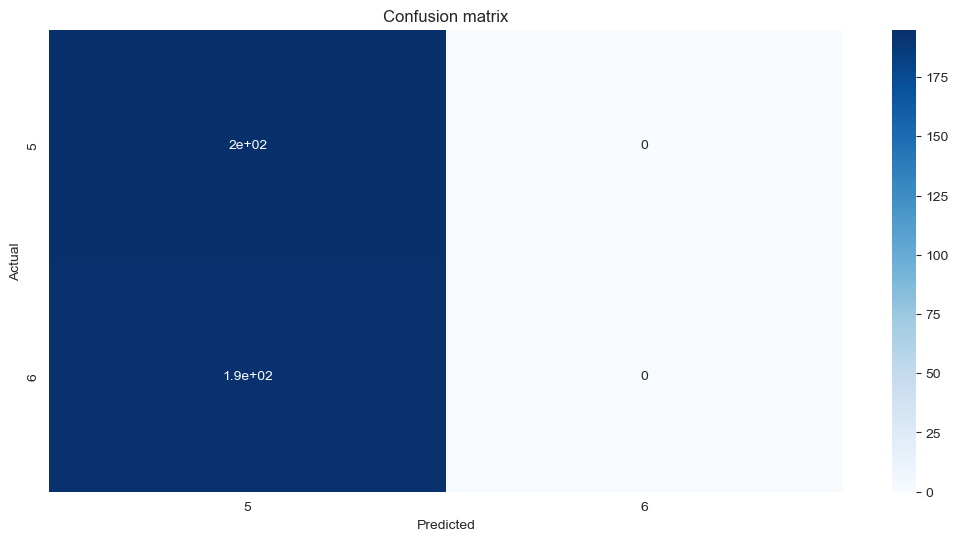

MLP_pca12_channel_csp15
Results for pipeline with MLP_pca12_channel_csp15:
----------------
Test accuracy scores: 0.5012853470437018
----------------
train accuracy scores: 0.4994487320837927

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.5013    1.0000    0.6678       195
           6     0.0000    0.0000    0.0000       194

    accuracy                         0.5013       389
   macro avg     0.2506    0.5000    0.3339       389
weighted avg     0.2513    0.5013    0.3348       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


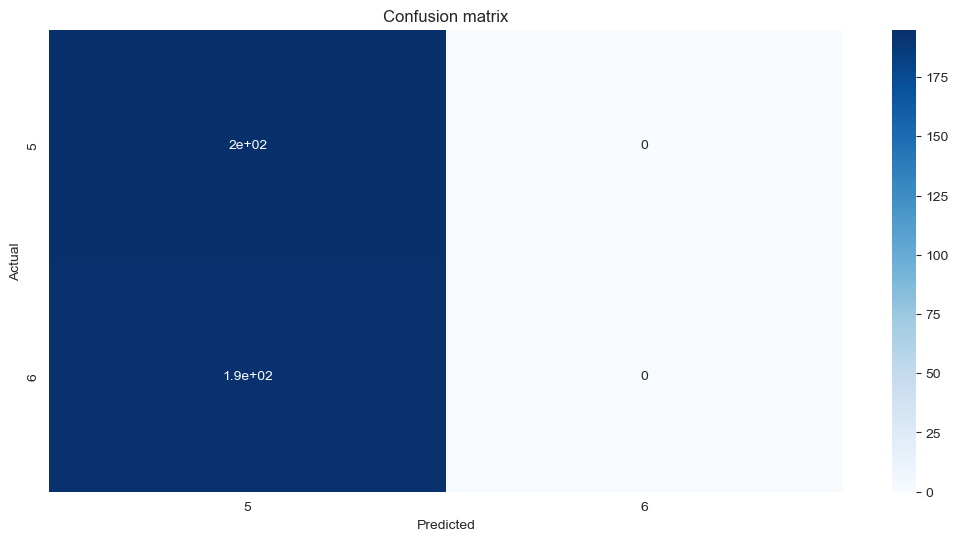

MLP_pca16_data_csp15
Results for pipeline with MLP_pca16_data_csp15:
----------------
Test accuracy scores: 0.5347043701799485
----------------
train accuracy scores: 0.5953693495038589

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.5368    0.5231    0.5299       195
           6     0.5327    0.5464    0.5394       194

    accuracy                         0.5347       389
   macro avg     0.5348    0.5347    0.5347       389
weighted avg     0.5348    0.5347    0.5346       389



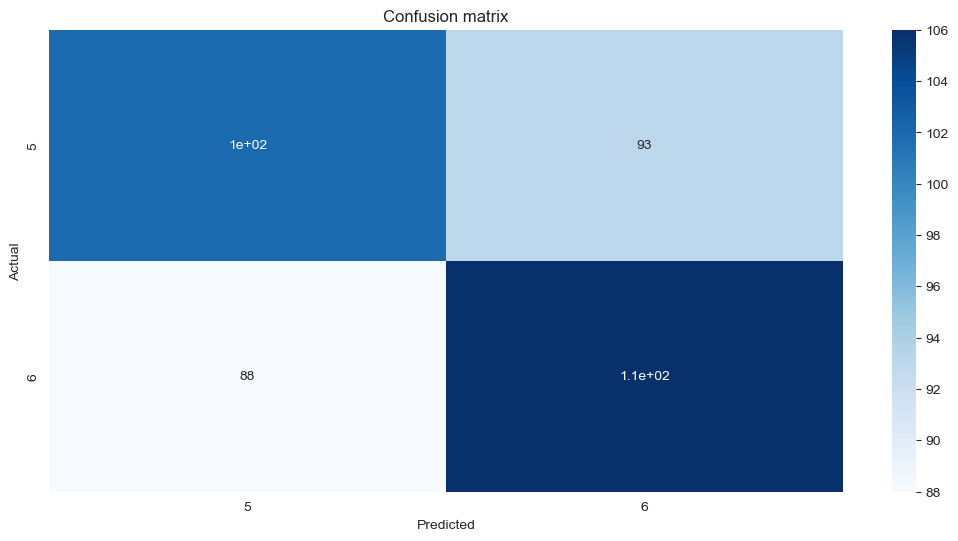

Keras_MLP_csp4
Results for pipeline with Keras_MLP_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


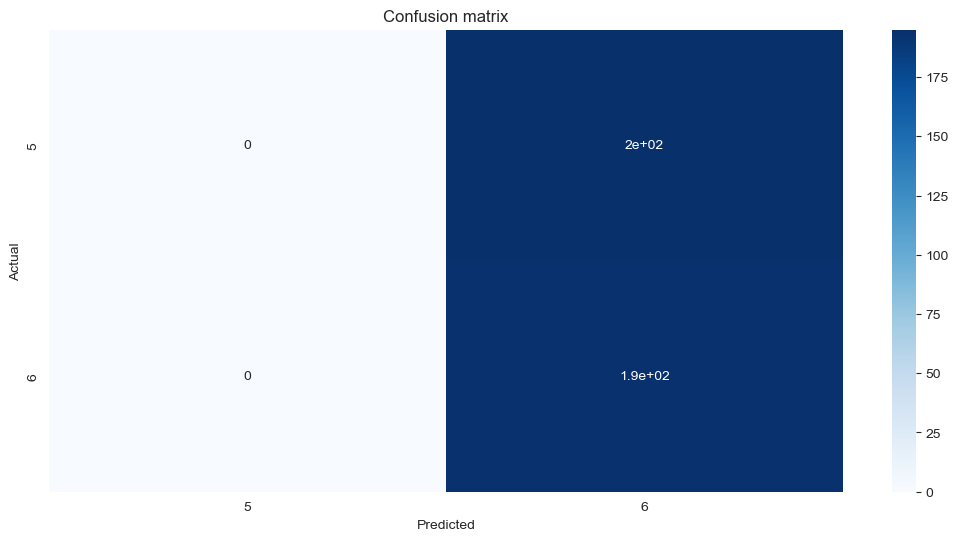

Keras_MLP_csp15
Results for pipeline with Keras_MLP_csp15:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


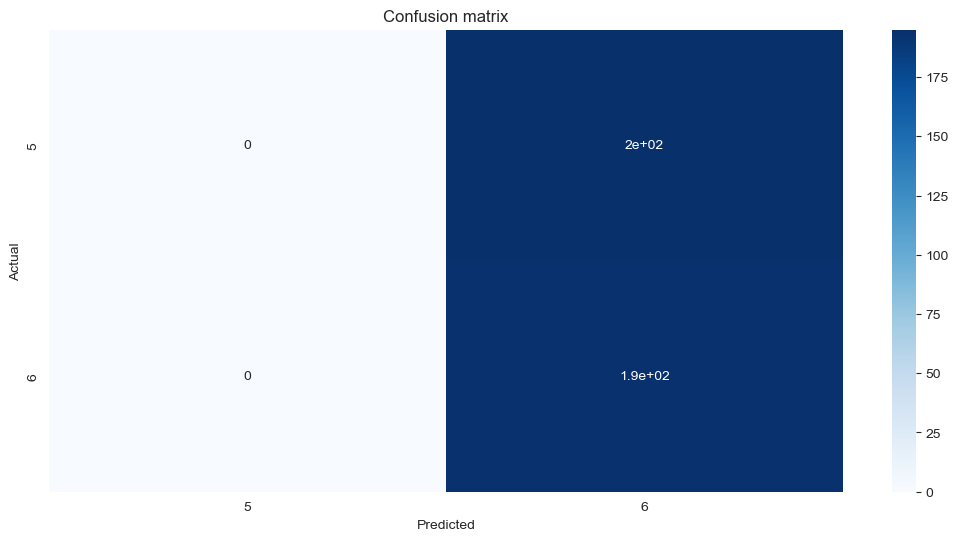

Keras_MLP_pca12_channel
Results for pipeline with Keras_MLP_pca12_channel:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


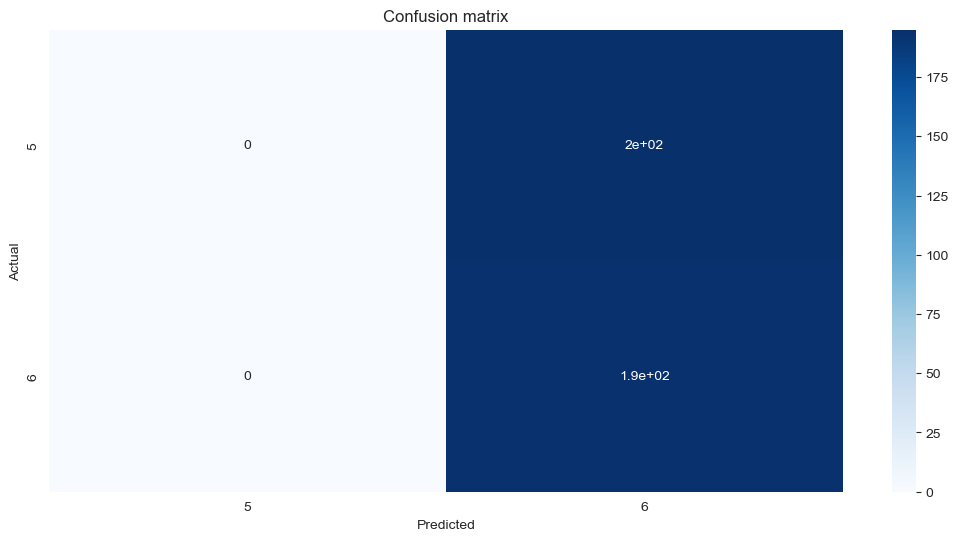

Keras_MLP_pca16_data
Results for pipeline with Keras_MLP_pca16_data:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


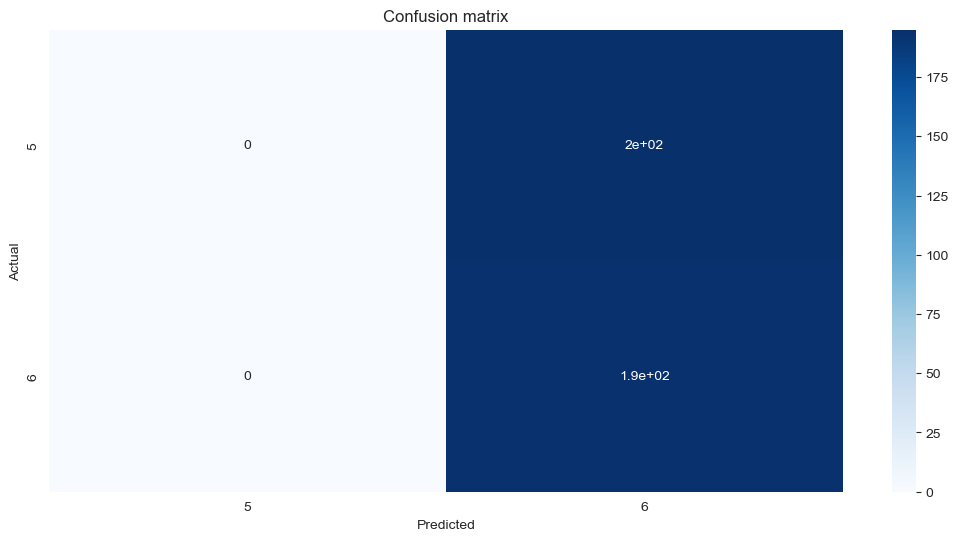

Keras_MLP_pca900_all
Results for pipeline with Keras_MLP_pca900_all:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


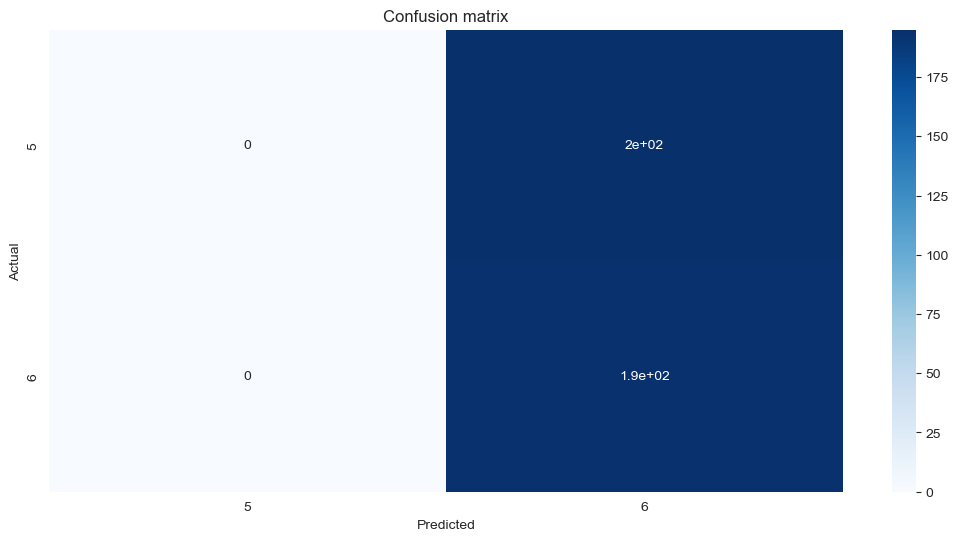

Keras_MLP_pca16_data_csp4
Results for pipeline with Keras_MLP_pca16_data_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


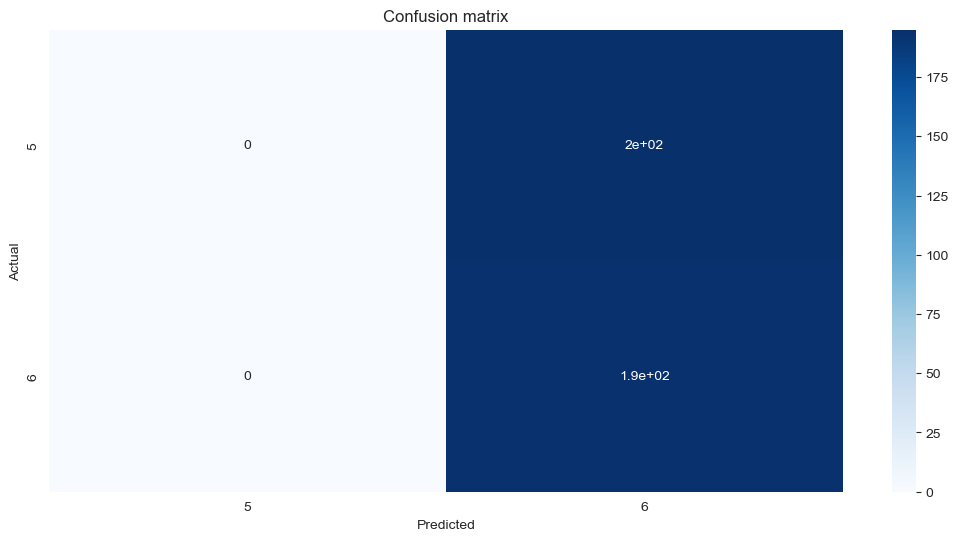

Keras_MLP_pca12_channel_csp4
Results for pipeline with Keras_MLP_pca12_channel_csp4:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


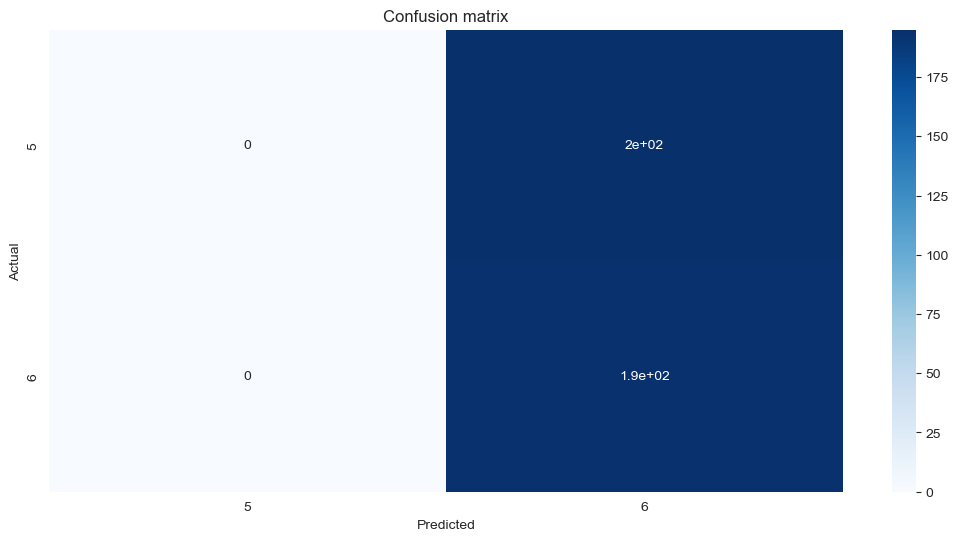

Keras_MLP_pca16_data_csp15
Results for pipeline with Keras_MLP_pca16_data_csp15:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


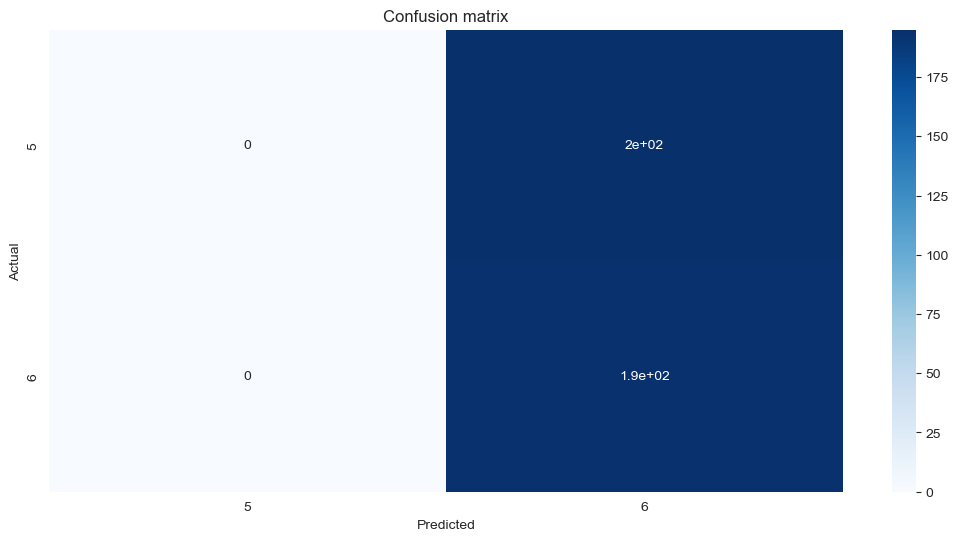

Keras_MLP_pca12_channel_csp15
Results for pipeline with Keras_MLP_pca12_channel_csp15:
----------------
Test accuracy scores: 0.4987146529562982
----------------
train accuracy scores: 0.5005512679162073

--------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           5     0.0000    0.0000    0.0000       195
           6     0.4987    1.0000    0.6655       194

    accuracy                         0.4987       389
   macro avg     0.2494    0.5000    0.3328       389
weighted avg     0.2487    0.4987    0.3319       389



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


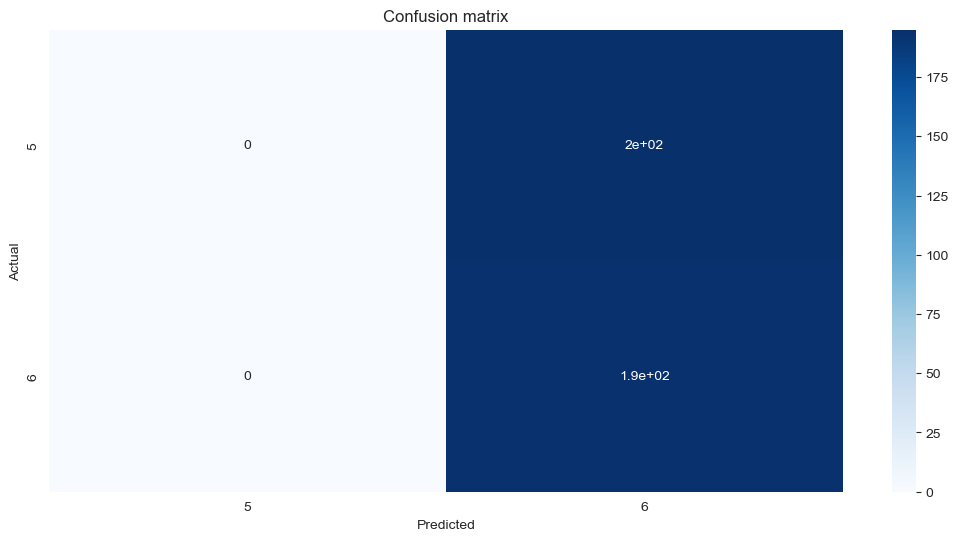

In [ ]:
results_val = {}
for pipe in Pipes:
    print(pipe.name)
    # Create pipeline with the given pipe
    pipeline = pipe.create_pipeline()
    
    # Perform cross-validation
    pipeline.fit( pipe.processed_X_train, y_train)
    train_score = pipeline.score(pipe.processed_X_train,y_train)
    val_score = pipeline.score(pipe.processed_X_val,y_val)


    print(f"Results for pipeline with {pipe.name}:")
    print("----------------")
    print("Test accuracy scores:", val_score)
    print("----------------")
    print("train accuracy scores:", train_score)
    print()
    print("--------------------------------------------------------------------------------------------")

    results_val[pipe.name] = (pipeline)
    f1,acc = display_results(pd.DataFrame(y_val)[0],pipeline.predict(pipe.processed_X_val))


In [ ]:
len(y_val)

389

In [ ]:
np.sum(y_val)

2139

In [ ]:
1347-673

674

In [ ]:
674/1347


0.5003711952487008

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [ ]:
pipe.processed_X_val[:, n : (n + w_length)]

array([], shape=(389, 0), dtype=float64)

In [ ]:
results_val["lda_pca12_channel_csp4"]

Pipeline(steps=[('model', LinearDiscriminantAnalysis())])

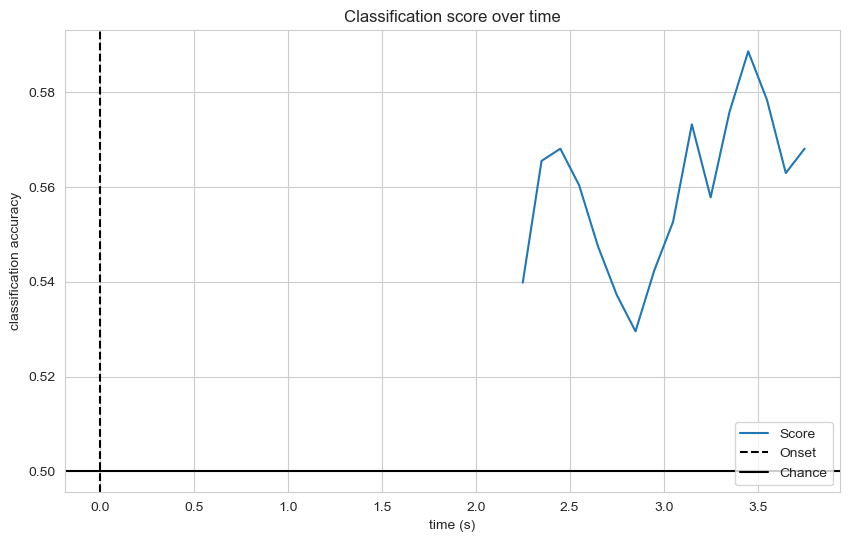

In [64]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data_train.shape[2] - w_length, w_step)

scores_windows = []


# running classifier: test classifier on sliding window
score_this_window = []
for n in w_start:
    transform_list = []
    for event in X_val[:, :, n : (n + w_length)]:
        transform_list.append(pca12_channel.transform(event.T))
    transform_list = np.stack(transform_list, axis=2) 
    X_val_windoed_csp15 = pca12_channel_csp15.transform(transform_list.T)
    score_this_window.append(results_val["lda_pca12_channel_csp15"].score(X_val_windoed_csp15, y_val))
scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs_train.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()